# arXiv Monthly Submissions

### Caveats
Here are some caveats to consider, taken from the [arXiv website](https://arxiv.org).
> _While we have attempted to extract download data representing unique full-text downloads by real users, there are many factors which affect accuracy. These factors include:_
    >>1. _the data is from the main [arXiv site](https://arxiv.org) and the arXiv mirrors, though some mirror data is incomplete;_
    >>2. _only web downloads are included (and not FTP or email "downloads" that were formerly supported);_
    >>3. _we have counted downloads according to the COUNTER algorithm which excludes rapid repeat downloads;_
    >>4. _we have attempted to identify and remove robot or automated downloads from the count (false positives lead to undercounting, failing to identify robots leads to overcounting);_
    >>5. _data prior to 2009 has not been cleaned with as much care as later data, it shows trends nonetheless._

In [1]:
from warnings import filterwarnings
filterwarnings('ignore')

# The usual suspects ...
import time_series as ts
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels

# And their accomplices ...
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA

# Plotting settings
sns.set(context='notebook', style='whitegrid', palette='deep', rc=None)

In [2]:
# Getting the data
downloads = pd.read_csv(
    'get_monthly_downloads_extracted_09-08-2018.csv')
submissions = pd.read_csv(
    'get_monthly_submissions_extracted_09-08-2018.csv')
data = pd.merge(submissions, downloads, on='month')

# Create a new file with the combined data
data.to_csv(
    'combined_submissions_and_downloads.csv', 
    sep=',',
    index=False)

Inspecting the dataset.

In [3]:
# Top 10 rows
data.head(10)

month  submissions  historical_delta  downloads
0  1994-01          582               -28          0
1  1994-02          634               -19       1863
2  1994-03          729               -24       7048
3  1994-04          699               -39       6814
4  1994-05          823               -18       9601
5  1994-06          856               -32      11007
6  1994-07          840               -23       9488
7  1994-08          746               -20      10789
8  1994-09          851               -33      12872
9  1994-10          909               -23      16260

In [4]:
# Description
data.describe()

submissions  historical_delta     downloads
count    295.000000        295.000000  2.950000e+02
mean    4783.718644         -6.464407  3.971368e+06
std     2929.850319         11.548386  4.847793e+06
min      582.000000        -49.000000  0.000000e+00
25%     2440.500000         -6.500000  7.096755e+05
50%     4160.000000          0.000000  2.109079e+06
75%     6933.500000          0.000000  5.075808e+06
max    12595.000000          0.000000  2.014987e+07

In [5]:
# Missing data
data.isnull().sum()

month               0
submissions         0
historical_delta    0
downloads           0
dtype: int64

| Columns | Description | Data Type | Action |
| :---: | :---: | :---: | :---: |
| `month` | month of activity | `string` | change to `datetime` |
| `submissions` | number of submissions made on a particular month | `integer` | do nothing |
| `historical_delta` | _undefined_ | `integer` | do nothing |
| `downloads` | number of downloads made on a particular month | `integer` | do nothing |
 
Our dataset has 4 columns and 290 rows. There are no missing values. We'll now proceed with further cleaning of our data.

In [6]:
# Changing month to 'datetime'
ts.convert_to_datetime(data=data, column='month')
data.dtypes

month               datetime64[ns]
submissions                  int64
historical_delta             int64
downloads                    int64
dtype: object

We have successfully changed the `month` into a _datetime_ object.

***

### Number of submissions and downloads

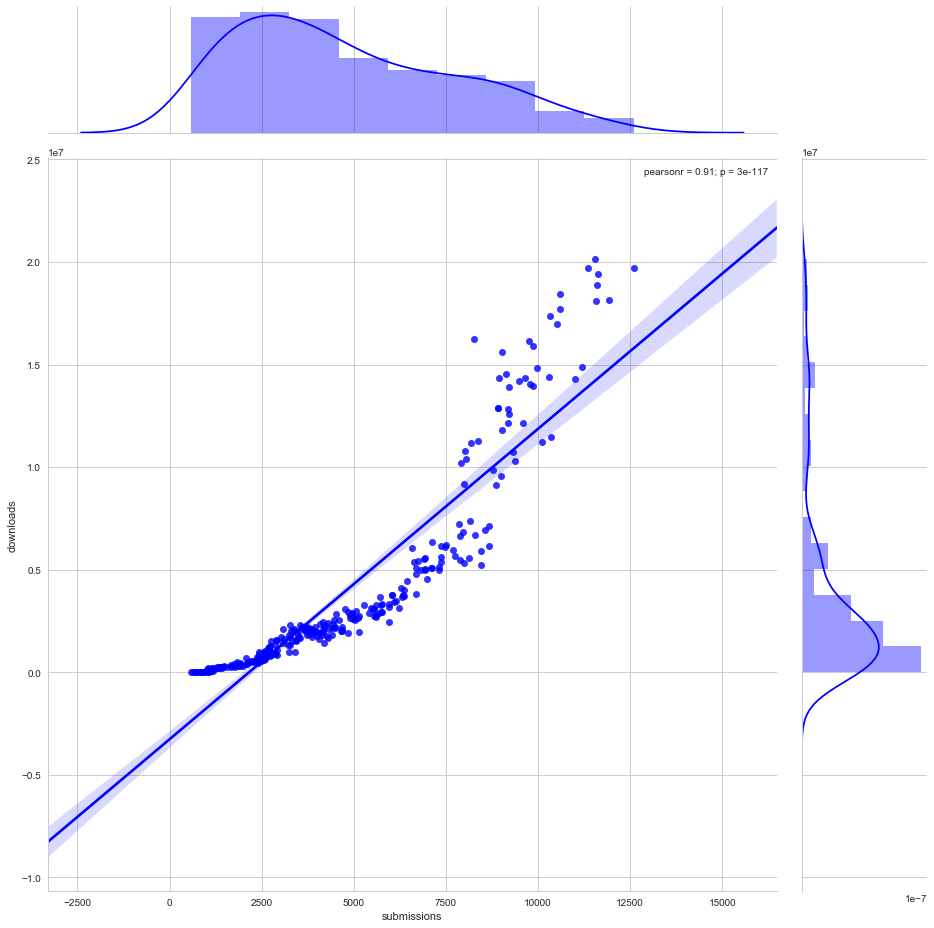

In [7]:
# Number of submissions vs. number of downloads
filterwarnings('ignore')
sns.jointplot(data=data, x='submissions', y='downloads', color='blue', kind='reg', size=13, )

Plotting the number of submissions against downloads, we find a strong linear correlation of $.91$ between the two variables. This tells us that as the number of submissions increases, so does the number of downloads.

From the scatterplot, we also find that submissions are more densely distributed in the range of $1 - 8000$. While on the other hand, downloads are more densely distributed in the range of $0 - 7.5$ million.

***

### Historical Delta ($h_\delta$)

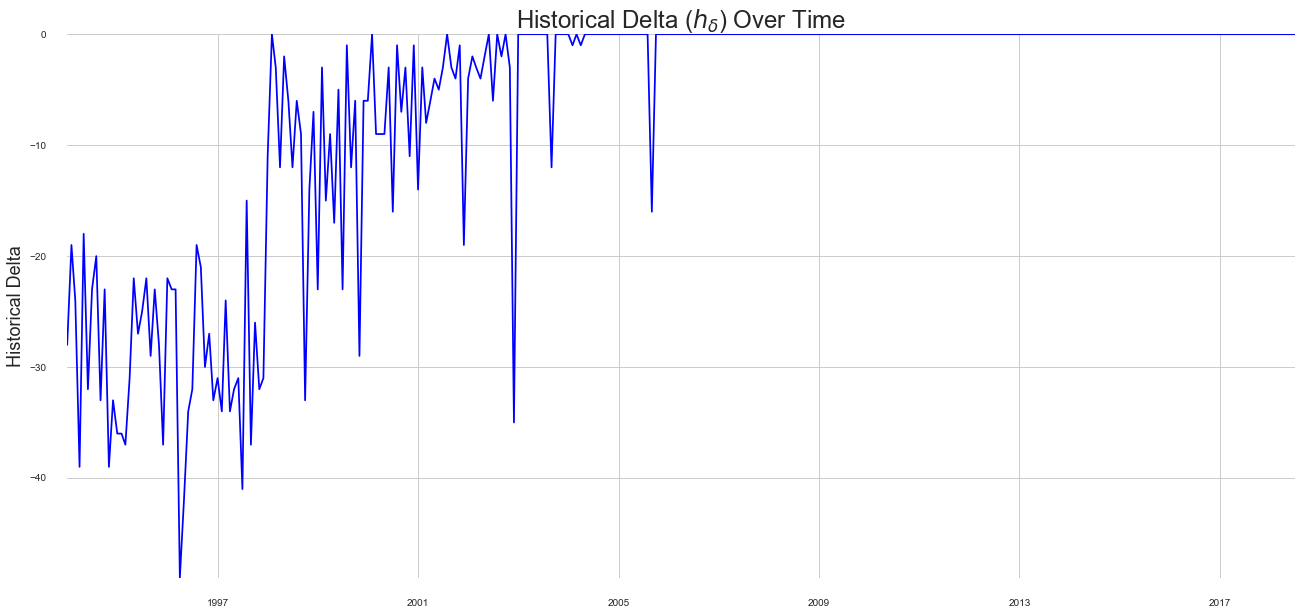

In [8]:
# Creating the time series
historical_delta = ts.create_series(data=data, time_column='month', category_column='historical_delta')

# Historical delta over time
ts.plot_series(historical_delta, title='Historical Delta ($h_{\delta}$) Over Time', ylabel='Historical Delta')

#### Stationarity of Historical Delta ($h_{\delta}$)

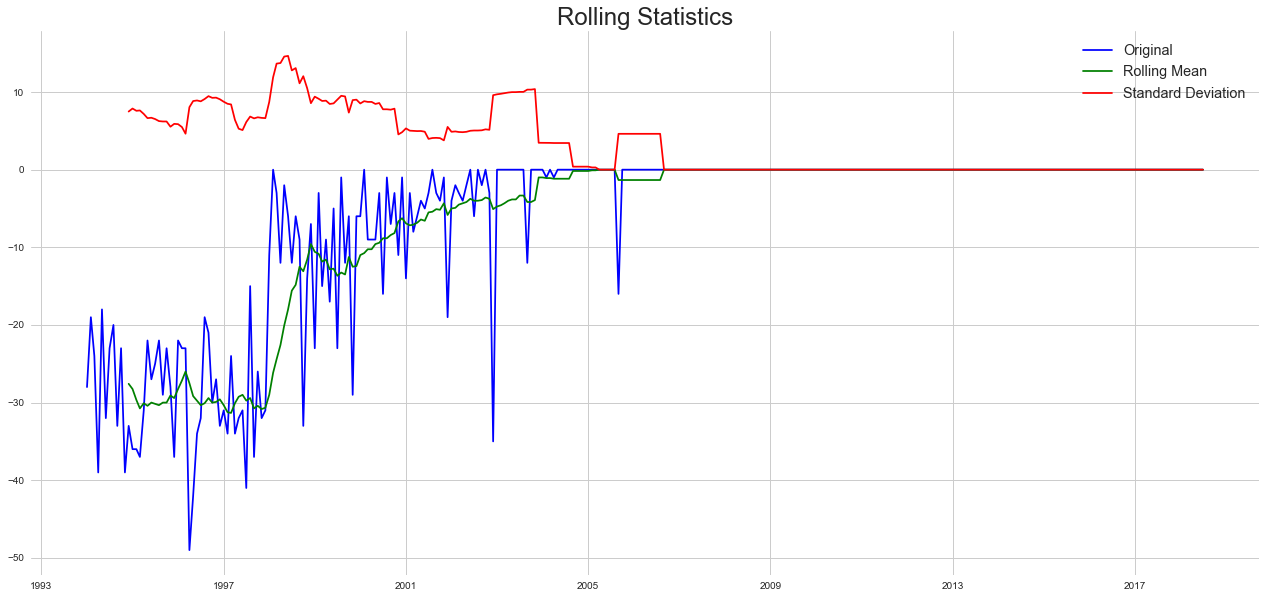

Results of Dickey-Fuller Test:
Test Statistic                  -2.294034
p-value                          0.173899
Number of Lags Used             11.000000
Number of Observations Used    283.000000
Critical Value (1%)             -3.453670
Critical Value (5%)             -2.871808
Critical Value (10%)            -2.572241
dtype: float64


In [9]:
ts.test_stationarity(historical_delta)

#### Summary

The _historical delta_ does not seem to show any trend or seasonality overtime. There are severe flactuations in the earlier years between $1994 - 2003$. After this period, the values are flatter along $0$.

Results from the Dickey-Fuller test show a test statistic value of $-2.27$, which is close to the critical values, further justifying a lack of trend.

***

### Submissions

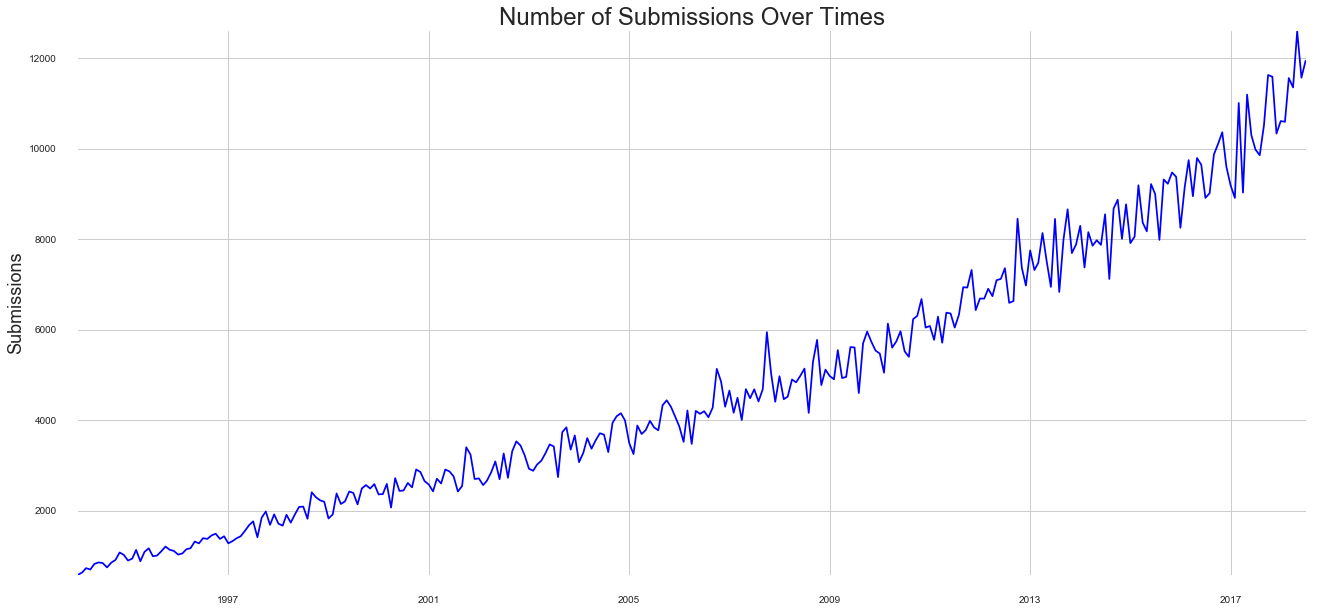

In [10]:
# Creating the submissions time series
submissions = ts.create_series(data=data, time_column='month', category_column='submissions')

# Number of submissions over time
ts.plot_series(submissions, title='Number of Submissions Over Time', ylabel='Submissions')

There has been a general upward trend in the number of submissions from $1994 - 2017$. There are relatively fewer flactuations in the period between $1994 - 2002$ compared to the period between $2003$ to the present date.

#### Stationarity of Submissions

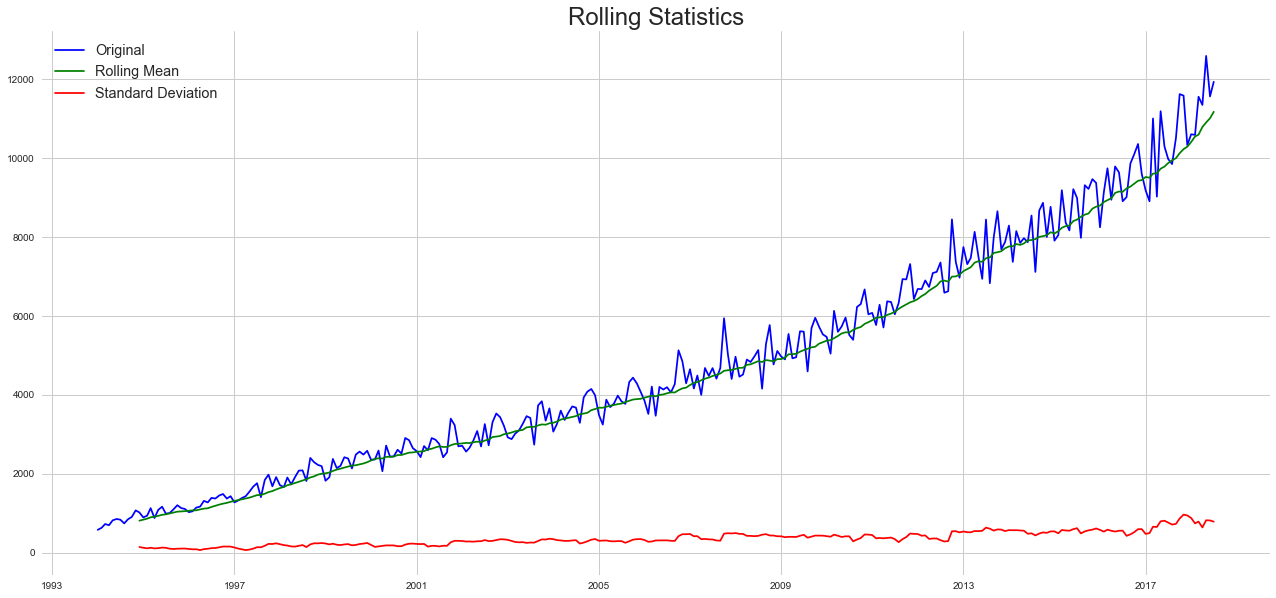

Results of Dickey-Fuller Test:
Test Statistic                   3.710055
p-value                          1.000000
Number of Lags Used             15.000000
Number of Observations Used    279.000000
Critical Value (1%)             -3.454008
Critical Value (5%)             -2.871956
Critical Value (10%)            -2.572320
dtype: float64


In [11]:
ts.test_stationarity(submissions)

We clearly have a rising trend over time. _This is not a stationary time series_. This can be observed from the rising mean, even though the standard deviation remains low.

We will now try to reducing the trend using logarithms. The intention is to penalize higher values more than lower values resulting in a flatter or less steeep trend.

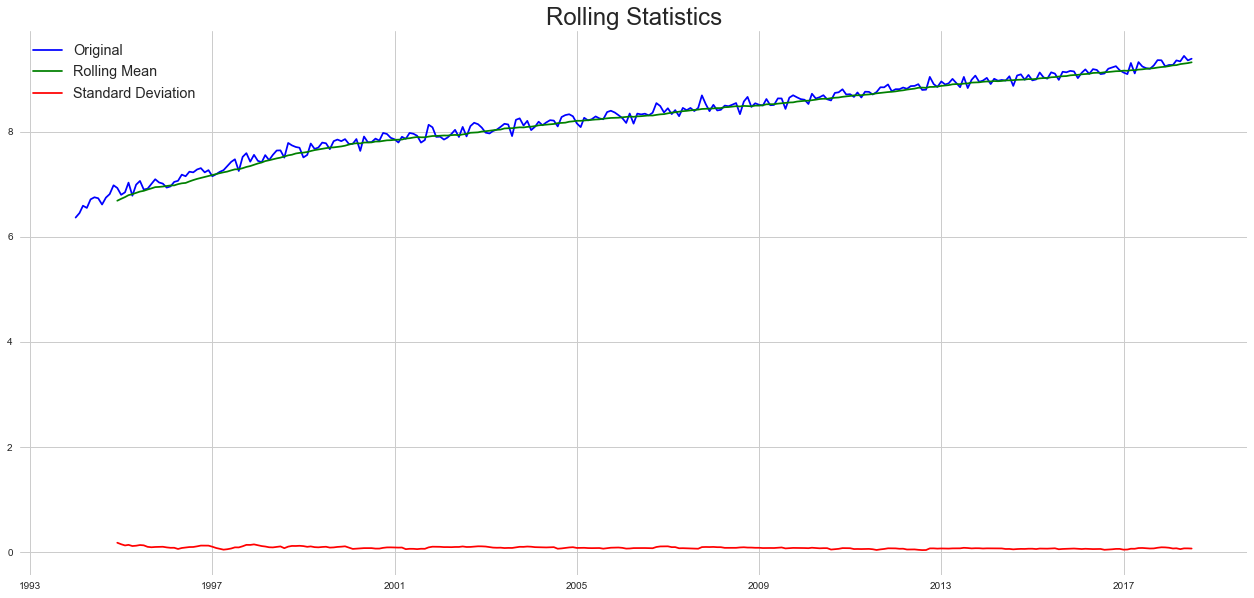

Results of Dickey-Fuller Test:
Test Statistic                  -3.149036
p-value                          0.023131
Number of Lags Used             14.000000
Number of Observations Used    280.000000
Critical Value (1%)             -3.453922
Critical Value (5%)             -2.871918
Critical Value (10%)            -2.572300
dtype: float64


In [12]:
# Reducing the trend by applying logarithms
submissions_log = np.log(submissions)

# Testing for stationarity
ts.test_stationarity(submissions_log)

The logarithms have tried to remove some of the steep trend and has also made the standard much more flat. However, closer inspection shows that we still have a rising trend

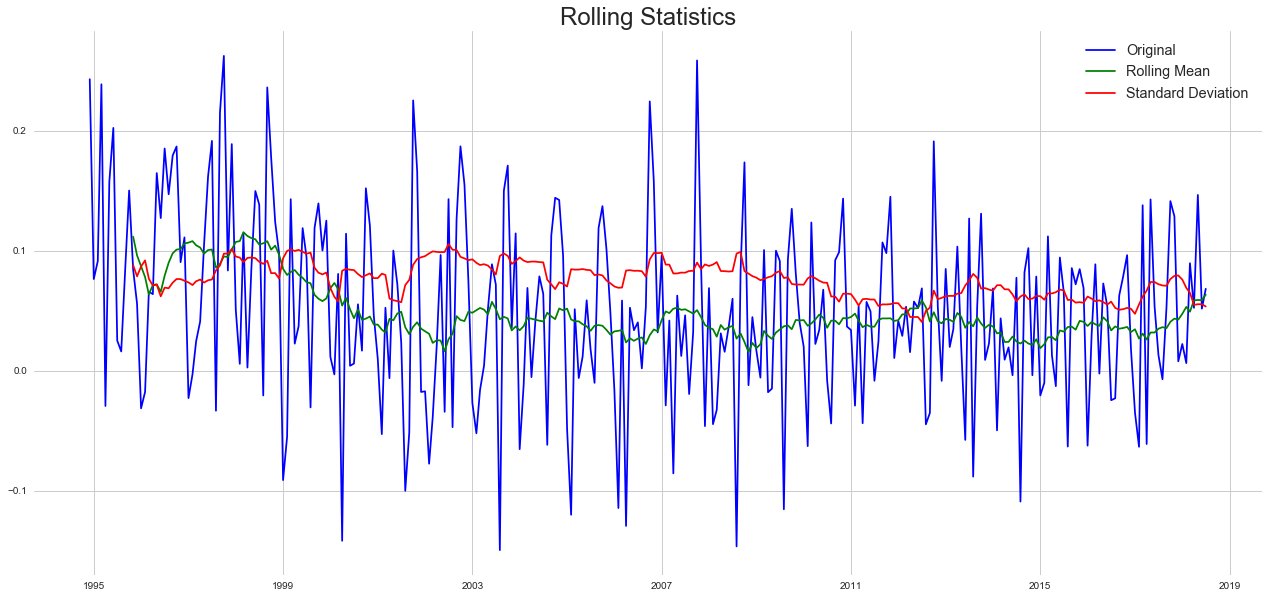

Results of Dickey-Fuller Test:
Test Statistic                  -1.970131
p-value                          0.299821
Number of Lags Used             14.000000
Number of Observations Used    269.000000
Critical Value (1%)             -3.454896
Critical Value (5%)             -2.872345
Critical Value (10%)            -2.572528
dtype: float64


In [13]:
# Removing the rolling mean
submissions_log_diff = submissions_log - submissions_log.rolling(window=12, center=False).mean().dropna()
submissions_log_diff.dropna(inplace=True)
ts.test_stationarity(submissions_log_diff)

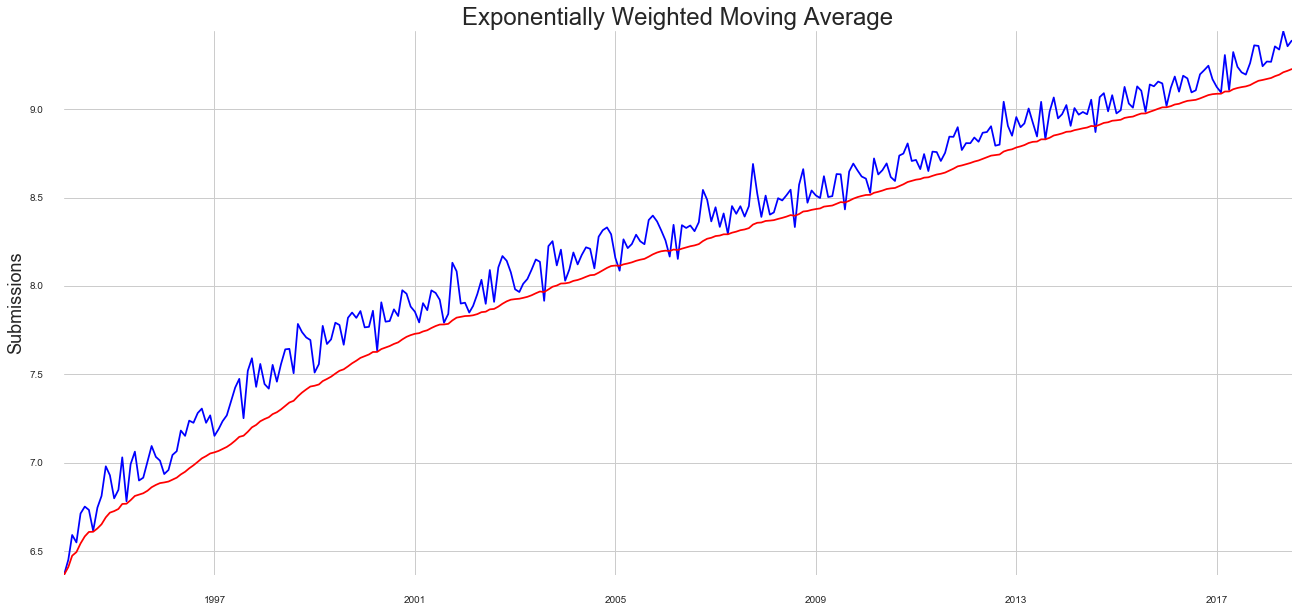

In [14]:
# Exponentially weighted moving average
ewa = submissions_log.ewm(halflife=12).mean()
ts.plot_series(data=submissions_log, 
               data2=ewa, 
               color='blue', 
               title='Exponentially Weighted Moving Average', 
               ylabel='Submissions')

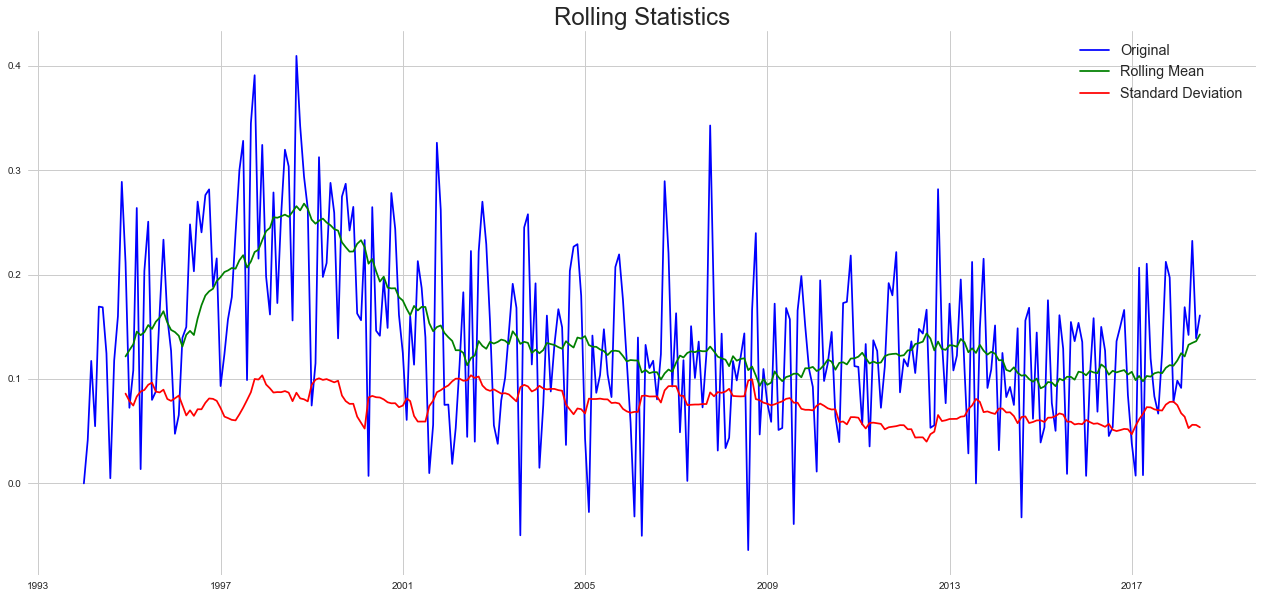

Results of Dickey-Fuller Test:
Test Statistic                  -1.392318
p-value                          0.585953
Number of Lags Used             14.000000
Number of Observations Used    280.000000
Critical Value (1%)             -3.453922
Critical Value (5%)             -2.871918
Critical Value (10%)            -2.572300
dtype: float64


In [15]:
# Removing the exponentially weighted mean from the series
submissions_log_ewa = submissions_log - ewa
submissions_log_ewa.dropna(inplace=True)
ts.test_stationarity(submissions_log_ewa)

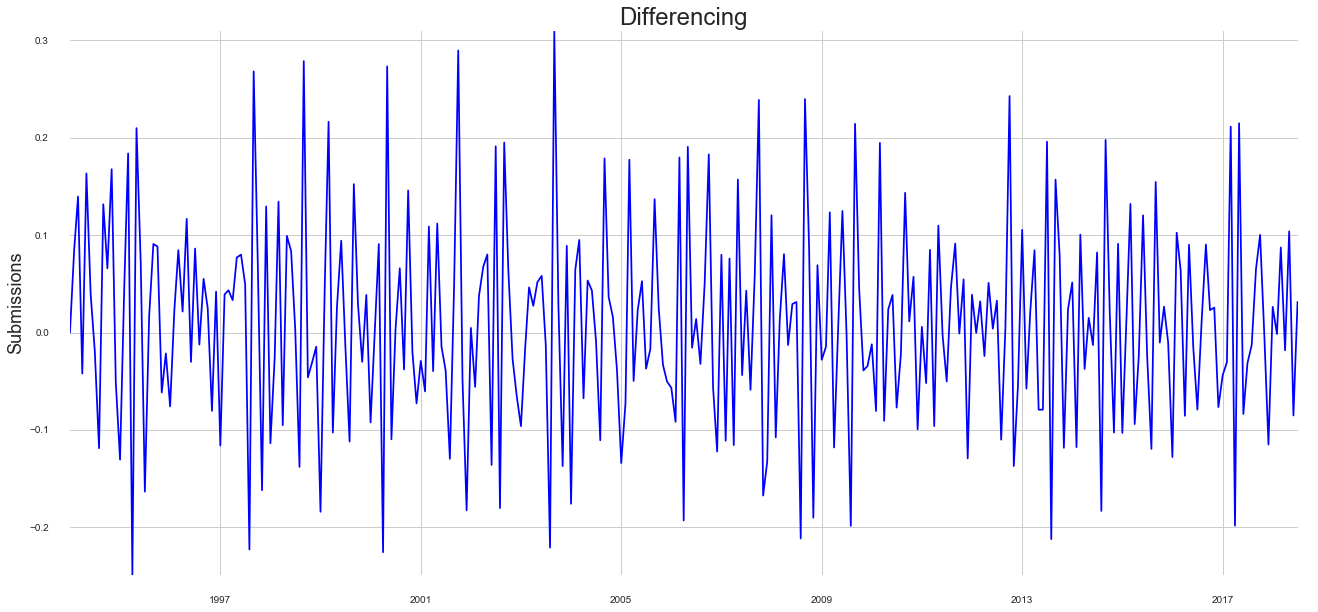

In [16]:
# Differencing
submissions_log_diff_shift = submissions_log - submissions_log.shift()
ts.plot_series(submissions_log_diff_shift, title='Differencing', ylabel='Submissions')

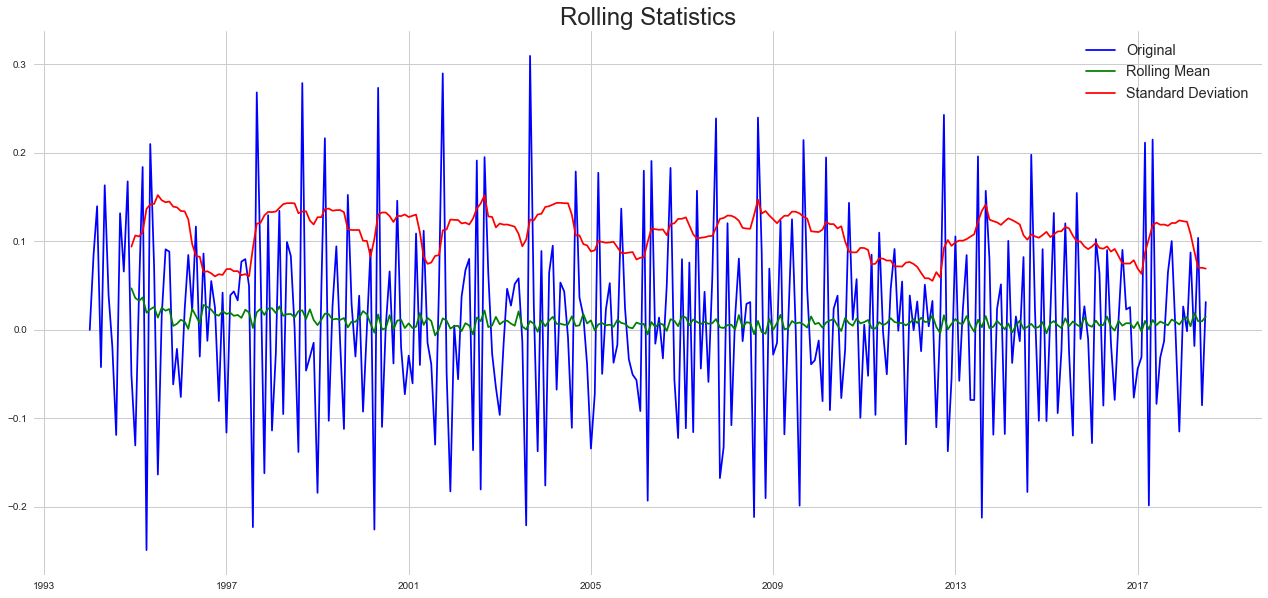

Results of Dickey-Fuller Test:
Test Statistic                  -5.370393
p-value                          0.000004
Number of Lags Used             13.000000
Number of Observations Used    281.000000
Critical Value (1%)             -3.453838
Critical Value (5%)             -2.871881
Critical Value (10%)            -2.572280
dtype: float64


In [17]:
submissions_log_diff_shift.dropna(inplace=True)
ts.test_stationarity(submissions_log_diff_shift)

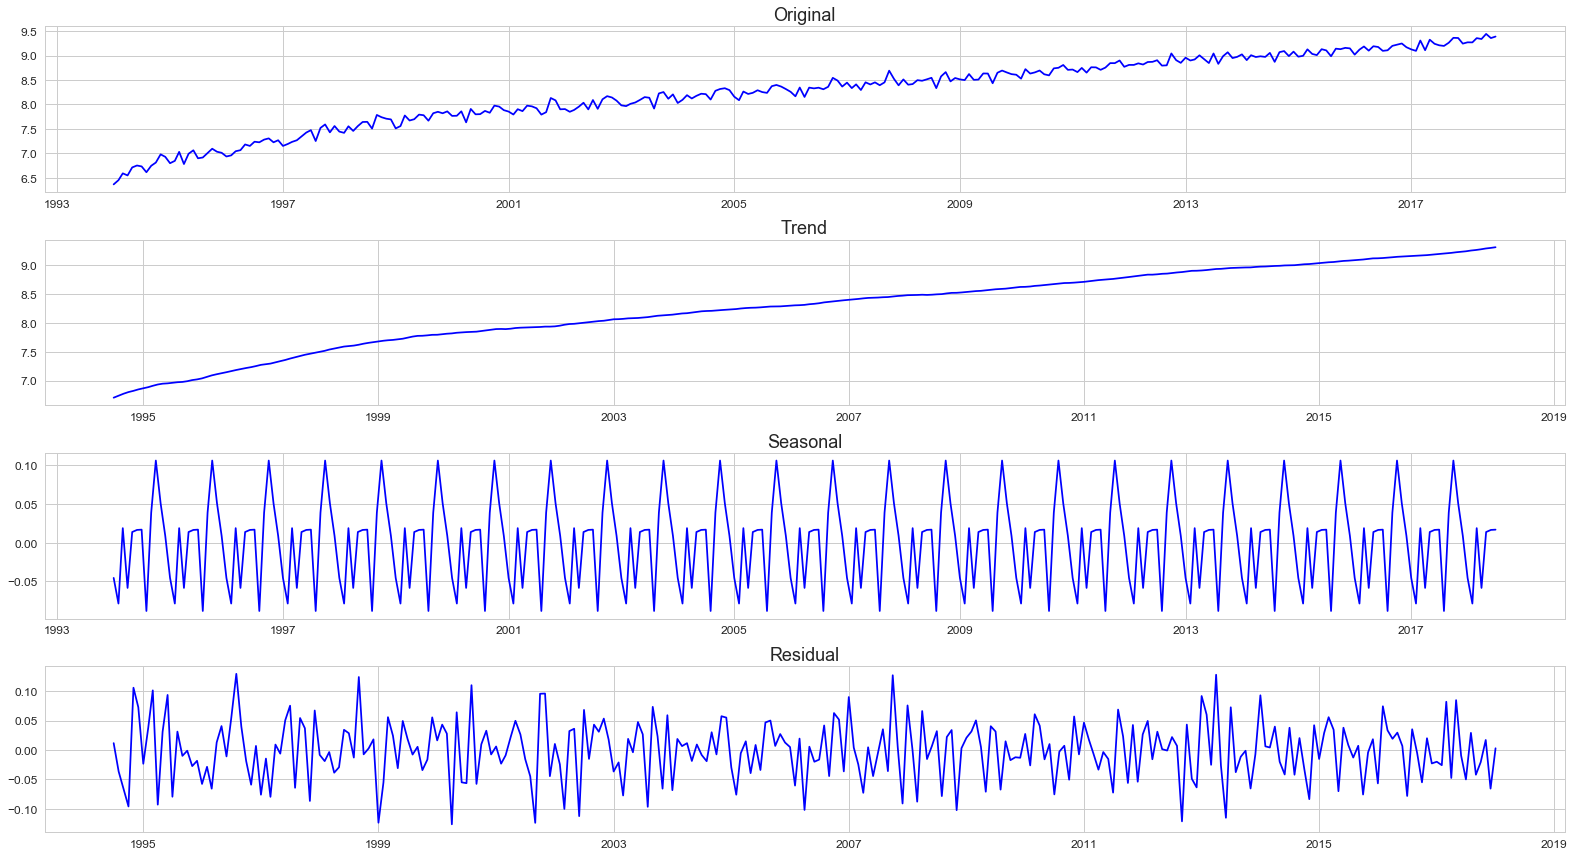

In [18]:
# Decomposing
decomposition = seasonal_decompose(submissions_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plotting
plt.figure(figsize=(22, 12))
# Original
plt.subplot(411)
plt.plot(submissions_log, color='blue')
plt.title('Original', fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# Trend
plt.subplot(412)
plt.plot(trend, color='blue')
plt.title('Trend', fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# Seasonal
plt.subplot(413)
plt.plot(seasonal, color='blue')
plt.title('Seasonal', fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# Residual
plt.subplot(414)
plt.plot(residual, color='blue')
plt.title('Residual', fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

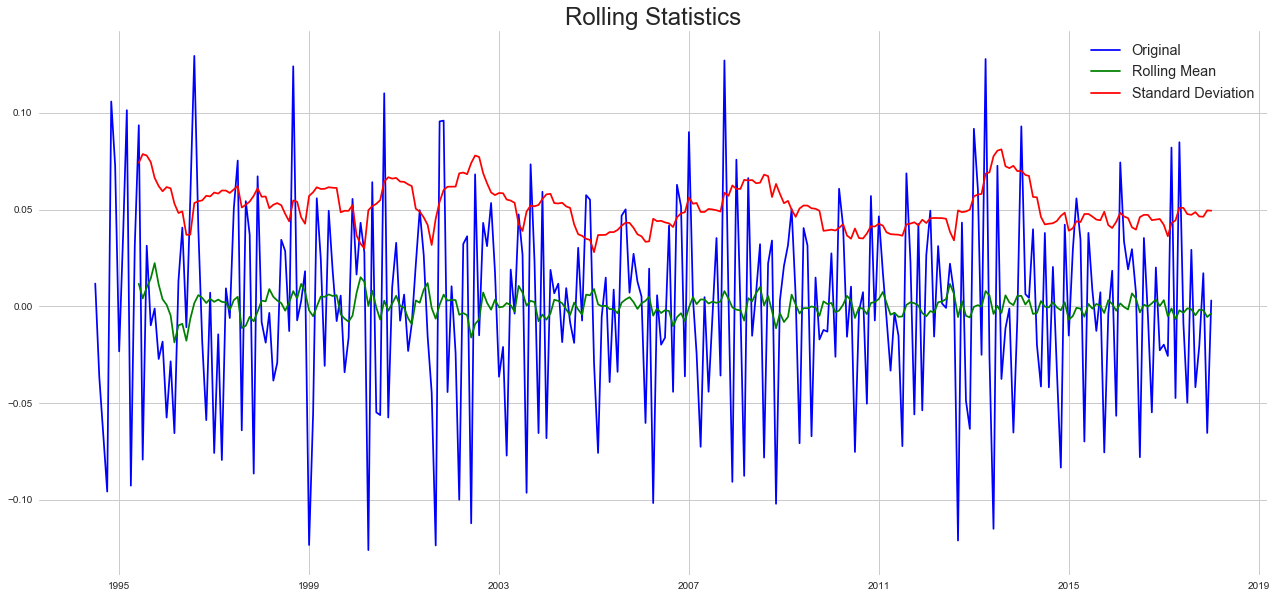

Results of Dickey-Fuller Test:
Test Statistic                -9.536692e+00
p-value                        2.796429e-16
Number of Lags Used            1.500000e+01
Number of Observations Used    2.670000e+02
Critical Value (1%)           -3.455081e+00
Critical Value (5%)           -2.872427e+00
Critical Value (10%)          -2.572571e+00
dtype: float64


In [19]:
# Checking stationarity of residuals
submissions_log_decompose_res = residual
submissions_log_decompose_res.dropna(inplace=True)
ts.test_stationarity(submissions_log_decompose_res)

In [20]:
# Forecasting
# ACF and PACF plots:
lag_acf = acf(submissions_log_diff_shift, nlags=20)
lag_pacf = pacf(submissions_log_diff_shift, nlags=20, method='ols')

# Plotting ACF
plt.figure(figsize=(22, 10))
plt.subplot(121)
plt.plot(lag_acf, color='blue')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(submissions_log)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(submissions_log)), linestyle='--', color='gray')
plt.title('Autocorrelation Function', fontsize=24)

# Plotting PACF
plt.subplot(122)
plt.plot(lag_pacf, color='blue')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(submissions_log)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(submissions_log)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function', fontsize=24)
plt.tight_layout()

In [21]:
# AR Model
filterwarnings('ignore')
model = ARIMA(submissions_log_diff_shift, order=(1, 2, 0))
results_AR = model.fit(disp=-1)

# Plotting
ts.plot_series(data=submissions_log_diff_shift, 
               data2=results_AR.fittedvalues,
               ylabel='Submissions', 
               title='RSS: {}'.format(sum((results_AR.fittedvalues - submissions_log_diff_shift).fillna(0))**2))

In [22]:
print(results_AR.summary())

                             ARIMA Model Results                              
Dep. Variable:         D2.submissions   No. Observations:                  293
Model:                 ARIMA(1, 2, 0)   Log Likelihood                  11.757
Method:                       css-mle   S.D. of innovations              0.232
Date:                Fri, 10 Aug 2018   AIC                            -17.514
Time:                        09:57:40   BIC                             -6.474
Sample:                    03-01-1994   HQIC                           -13.092
                         - 07-01-2018                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.0003      0.008     -0.034      0.973      -0.016       0.015
ar.L1.D2.submissions    -0.6891      0.042    -16.357      0.000      -0.772      -0.607
            

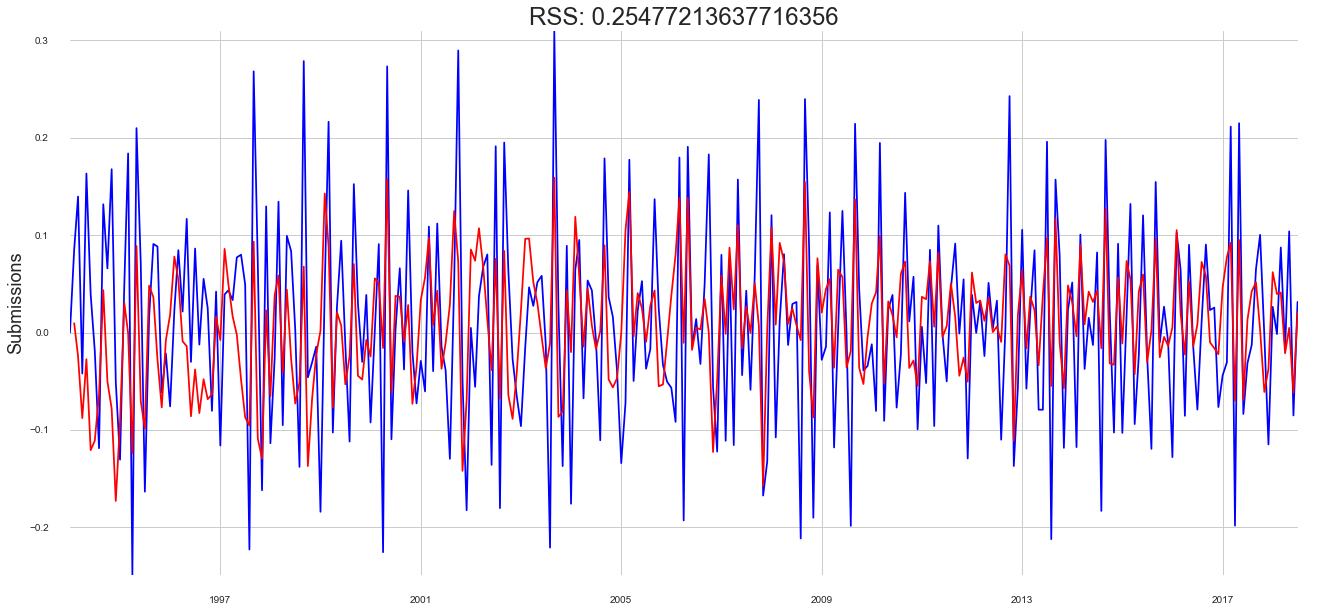

In [23]:
# MA Model
filterwarnings('ignore')
model = ARIMA(submissions_log, order=(0, 1, 2))
results_MA = model.fit(disp=-1)

# Plotting
ts.plot_series(data=submissions_log_diff_shift, 
               data2=results_MA.fittedvalues,
               ylabel='Submissions', 
               title='RSS: {}'.format(sum((results_MA.fittedvalues - submissions_log_diff_shift).fillna(0))**2))

In [24]:
print(results_MA.summary())

                             ARIMA Model Results                              
Dep. Variable:          D.submissions   No. Observations:                  294
Model:                 ARIMA(0, 1, 2)   Log Likelihood                 303.679
Method:                       css-mle   S.D. of innovations              0.086
Date:                Fri, 10 Aug 2018   AIC                           -599.357
Time:                        09:57:41   BIC                           -584.623
Sample:                    02-01-1994   HQIC                          -593.457
                         - 07-01-2018                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0096      0.001      8.386      0.000       0.007       0.012
ma.L1.D.submissions    -0.7181      0.064    -11.185      0.000      -0.844      -0.592
ma.L2.D.submissi

In [25]:
# ARIMA Model
filterwarnings('ignore')
model = ARIMA(submissions_log, order=(1, 1, 2))
results_ARIMA = model.fit(disp=-1)

# Plotting
ts.plot_series(data=submissions_log_diff_shift, 
               data2=results_ARIMA.fittedvalues,
               ylabel='Submissions', 
               title='RSS: {}'.format(sum((results_ARIMA.fittedvalues - submissions_log_diff_shift).fillna(0))**2))

In [26]:
print(results_ARIMA.summary())

                             ARIMA Model Results                              
Dep. Variable:          D.submissions   No. Observations:                  294
Model:                 ARIMA(1, 1, 2)   Log Likelihood                 312.718
Method:                       css-mle   S.D. of innovations              0.083
Date:                Fri, 10 Aug 2018   AIC                           -615.435
Time:                        09:57:42   BIC                           -597.017
Sample:                    02-01-1994   HQIC                          -608.059
                         - 07-01-2018                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0124      0.005      2.684      0.008       0.003       0.022
ar.L1.D.submissions     0.9899      0.011     87.971      0.000       0.968       1.012
ma.L1.D.submissi

We have following results from the three models:

| **Measure** | **AR Model** | **MA Model** | **ARIMA Model** |
| :---------: | :----------: | :----------: | :-------------: |
|     RSS     |     8.311    |     0.255    |       1.493     |
|     AIC     |   -17.519    |  -599.357    |    -615.435     |
|     BIC     |    -6.747    |  -584.623    |    -597.017     |
|     HQIC    |   -13.092    |  -593.457    |    -608.059     |

The [`RSS`](https://en.wikipedia.org/wiki/Residual_sum_of_squares) show us the how well our models fit the data. A lower value suggests a _tight_ fit, while a higher value suggests a _loss_ fit. From the models, we find that the **MA** model gives us the lowest `RSS` value. However, the **ARIMA** model has a better [**Akaike Information Criterion (AIC)**](https://en.wikipedia.org/wiki/Akaike_information_criterion) value compared to the other three models.

We will use the **MA** model to predict.

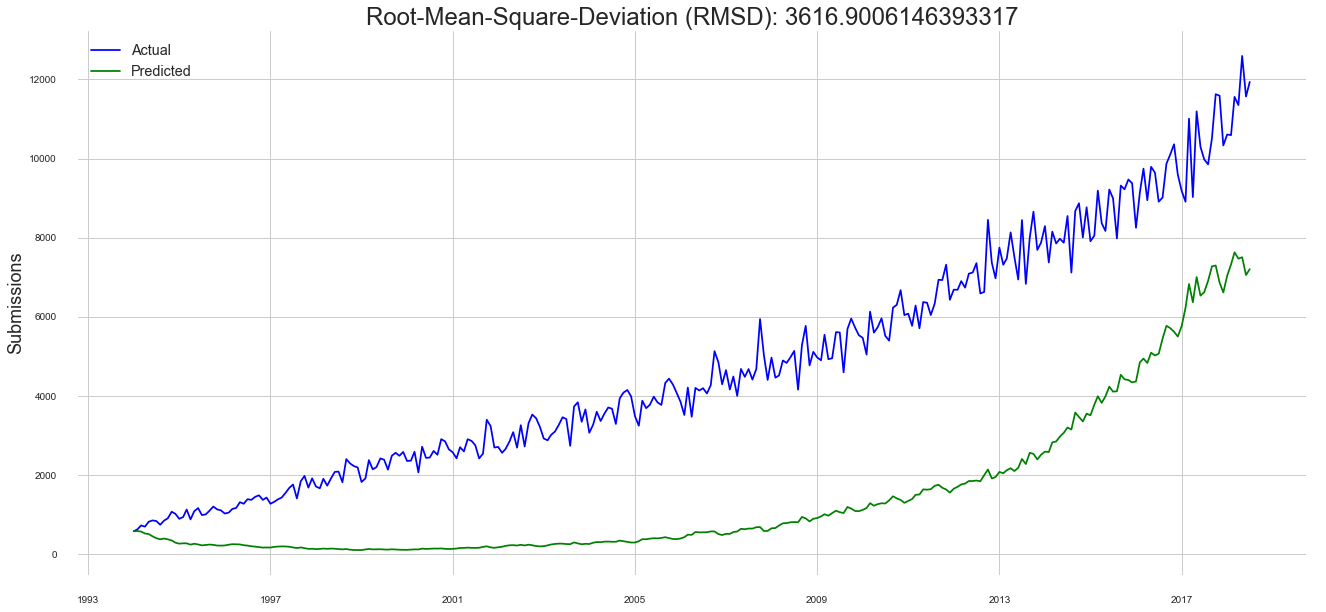

In [27]:
# Predicting with MA
# Reversing to the original scale
predictions_MA_diff = pd.Series(results_MA.fittedvalues, copy=True)

# Cumulative sum
predictions_MA_diff_cumsum = predictions_MA_diff.cumsum()

# Adding the base number
predictions_MA_log = pd.Series(submissions_log.ix[0], index=submissions_log.index)
predictions_MA_log = predictions_MA_log.add(predictions_MA_diff_cumsum, fill_value=0)

# Taking the exponent
predictions_MA = np.exp(predictions_MA_log)

# Plotting
ts.plot_predictions(data=submissions, 
                    data2=predictions_MA, 
                    ylabel='Submissions', 
                    title='Root-Mean-Square-Deviation (RMSD): {}'.format(np.sqrt(sum((
                        predictions_MA - submissions)**2)/len(submissions))))

In [28]:
# Predicting with ARIMA
# Reversing to the original scale
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)

# Cumulative sum
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()

# Adding the base number
predictions_ARIMA_log = pd.Series(submissions_log.ix[0], index=submissions_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)

# Taking the exponent
predictions_ARIMA = np.exp(predictions_ARIMA_log)

# Plotting
ts.plot_predictions(data=submissions,
                    data2=predictions_ARIMA,
                    ylabel='Submissions',
                    title='Root-Mean-Square-Deviation (RMSD): {}'.format(np.sqrt(sum((
                        predictions_ARIMA - submissions)**2)/len(submissions))))

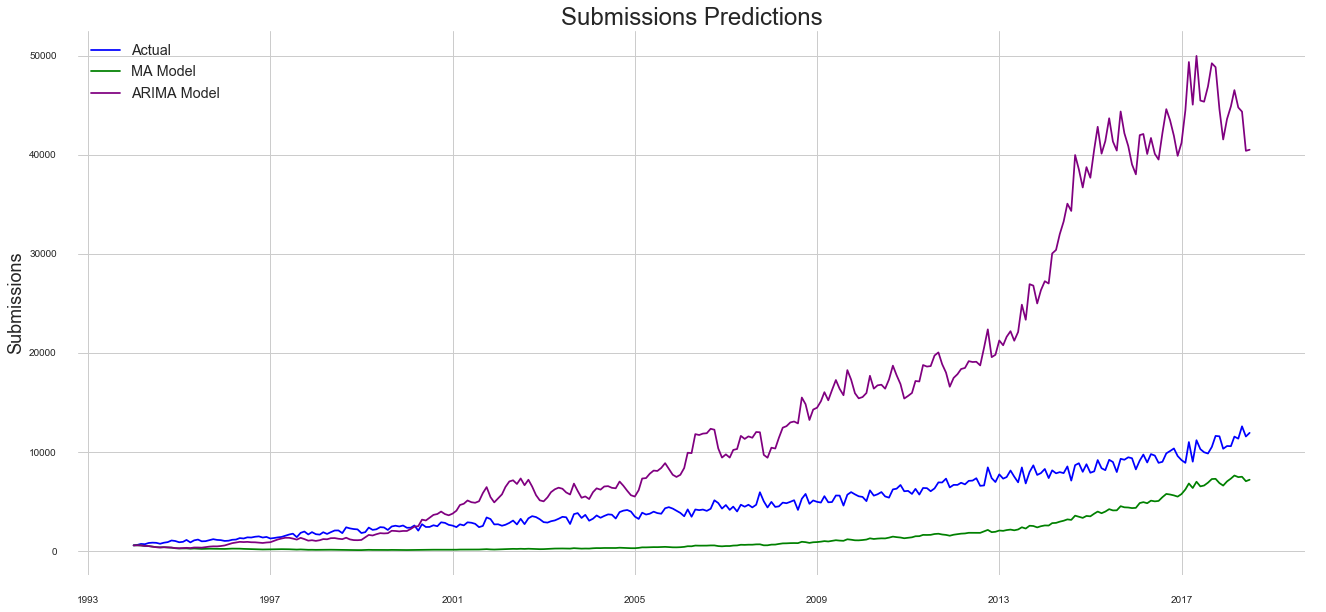

In [29]:
# Plotting
ts.plot_predictions(data=submissions,
                    data2=predictions_MA,
                    data3=predictions_ARIMA,
                    ylabel='Submissions',
                    title='Submissions Predictions',
                    l2='MA Model', 
                    l3='ARIMA Model')

### Summary

Having modelled the submissions data using three models: **AR, MA, & ARIMA**, we wanted to obtain a model that we could use to predict the next time-step of article submissions. From the results, two models were preferable:

> **MA** - because it had a lower residual-sum-of-squares (RSS) value compared to the other models.
> **ARIMA** - because it had a better AIC value compared to the other models.

We used both models to make predictions and obtained the following results:

| **Measure** | **MA Model** | **ARIMA Model** |
| :---------: | :----------: | :-------------: |
|     RMSD    |   3616.900   |   15082.662     |

This means, the **MA** model fits the actual data more tightly and has a smaller **RMSD** value when predicting. This is comparison to the **ARIMA** model which has deviation a higher deviation value. When we plot the actual values against the predictions from both models, we find that the **MA** model predicts below the observed submissions, while the **ARIMA** predicts above the observed submissions. However, the **MA** model predicts the actual submissions better.

***

### Downloads

In [30]:
# NB: This block takes a while to run
# Creating the time series
downloads = ts.create_series(data=data, time_column='month', category_column='downloads')

# Number of downloads over time
#ts.plot_series(downloads, title='Number of Downloads Over Time', ylabel='Downloads')

Over time, downloads show a rising trend from $1995$ and gained a lot of momentum in $2012$. The years after $2012$ show significant increases, however there is a decrease in $2016$. After the drop in $2016$, the number of downloads rises even higher reaching a peak of close to 2 million downloads towards the end of $2017$.

#### Stationarity of Downloads

In [31]:
ts.test_stationarity(downloads)

Results of Dickey-Fuller Test:
Test Statistic                   4.223103
p-value                          1.000000
Number of Lags Used             10.000000
Number of Observations Used    284.000000
Critical Value (1%)             -3.453587
Critical Value (5%)             -2.871771
Critical Value (10%)            -2.572222
dtype: float64


The Dickey-Fuller test shows a high test statistic relative to the sub-zero critical values. This means the number of downloads have a rolling mean that rises over time even though the standard deviation remains relatively low.

We also try to remove the trend in the downloads data by apply logarithms.

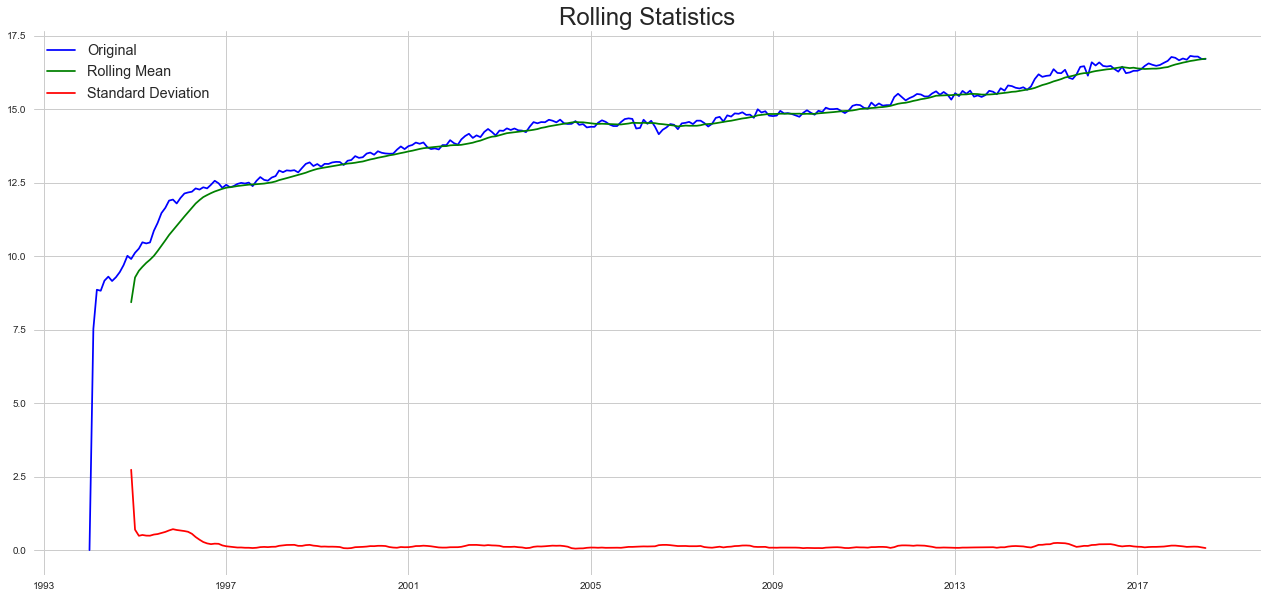

Results of Dickey-Fuller Test:
Test Statistic                  -1.664744
p-value                          0.449363
Number of Lags Used             16.000000
Number of Observations Used    278.000000
Critical Value (1%)             -3.454094
Critical Value (5%)             -2.871993
Critical Value (10%)            -2.572340
dtype: float64


In [32]:
# Removing seasonality and trend
downloads_log = np.log(downloads)
downloads_log = downloads_log.replace(np.negative(np.inf), 0)
downloads_log.dropna(inplace=True)
ts.test_stationarity(downloads_log)

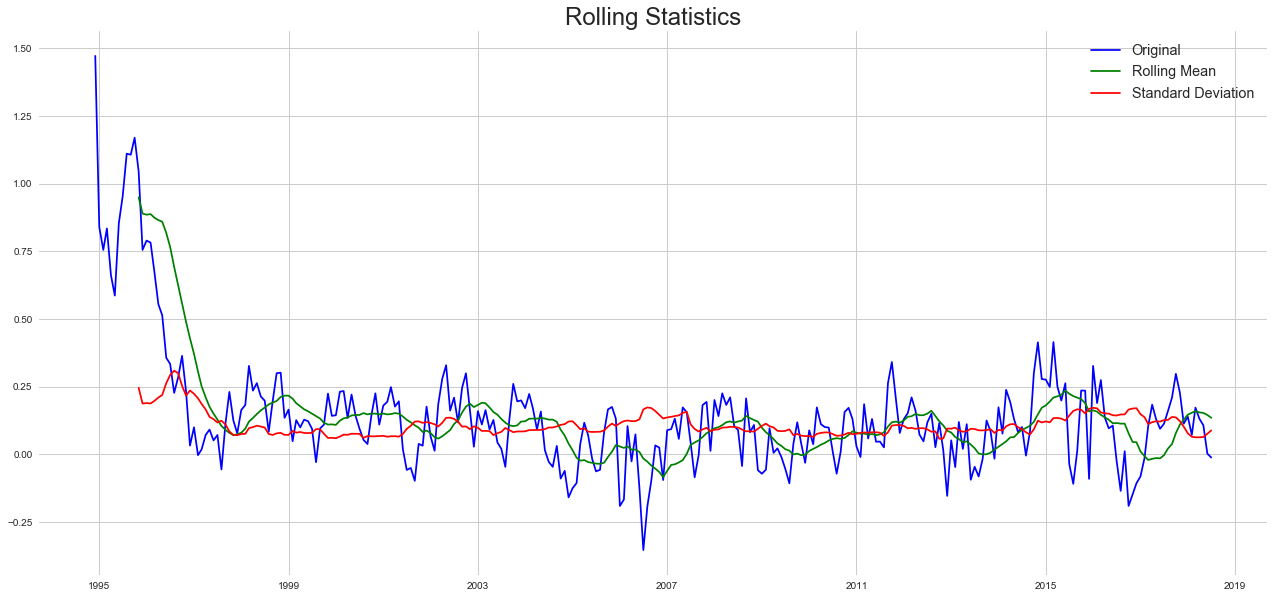

Results of Dickey-Fuller Test:
Test Statistic                  -5.435132
p-value                          0.000003
Number of Lags Used             12.000000
Number of Observations Used    271.000000
Critical Value (1%)             -3.454713
Critical Value (5%)             -2.872265
Critical Value (10%)            -2.572485
dtype: float64


In [33]:
# Removing the rolling mean
downloads_log_diff = downloads_log - downloads_log.rolling(window=12, center=False).mean().dropna()
downloads_log_diff.dropna(inplace=True)
ts.test_stationarity(downloads_log_diff)

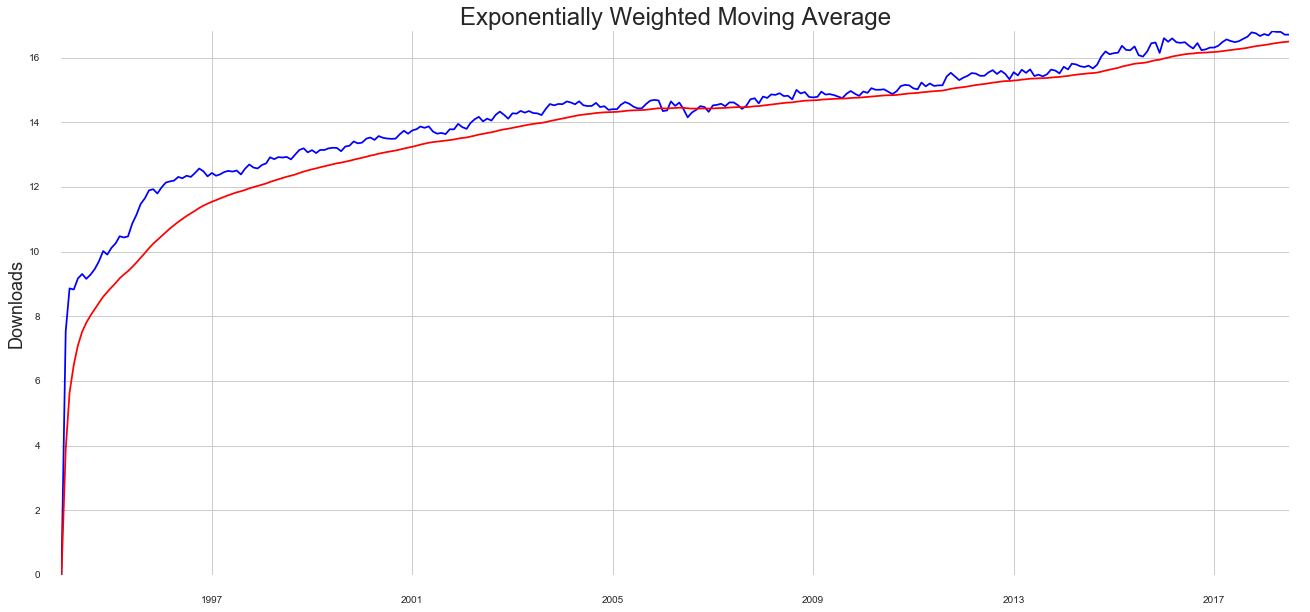

In [34]:
# Exponentially weighted moving average
ewa = downloads_log.ewm(halflife=12).mean()

# Plotting
ts.plot_series(data=downloads_log, 
               data2=ewa, 
               color='blue', 
               title='Exponentially Weighted Moving Average', 
               ylabel='Downloads')

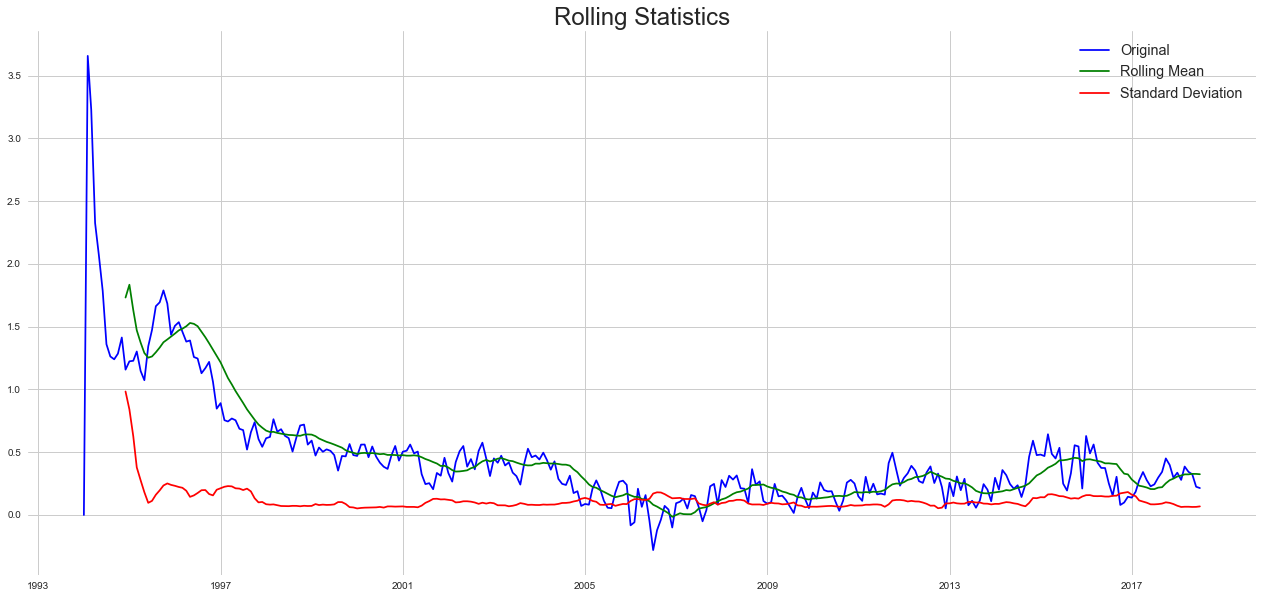

Results of Dickey-Fuller Test:
Test Statistic                  -2.957952
p-value                          0.039012
Number of Lags Used             15.000000
Number of Observations Used    279.000000
Critical Value (1%)             -3.454008
Critical Value (5%)             -2.871956
Critical Value (10%)            -2.572320
dtype: float64


In [35]:
# Removing the exponentially weighted mean from the series
downloads_log_ewa = downloads_log - ewa
downloads_log_ewa.dropna(inplace=True)
ts.test_stationarity(downloads_log_ewa)

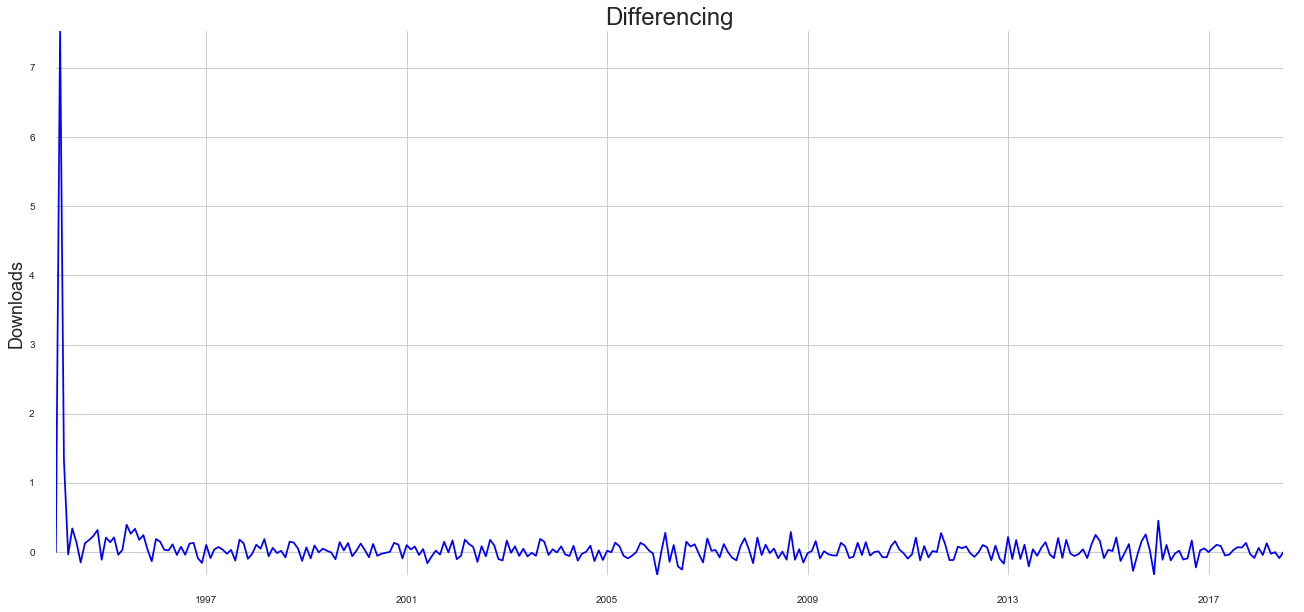

In [36]:
# Differencing
downloads_log_diff_shift = downloads_log - downloads_log.shift()
ts.plot_series(downloads_log_diff_shift, title='Differencing', ylabel='Downloads')

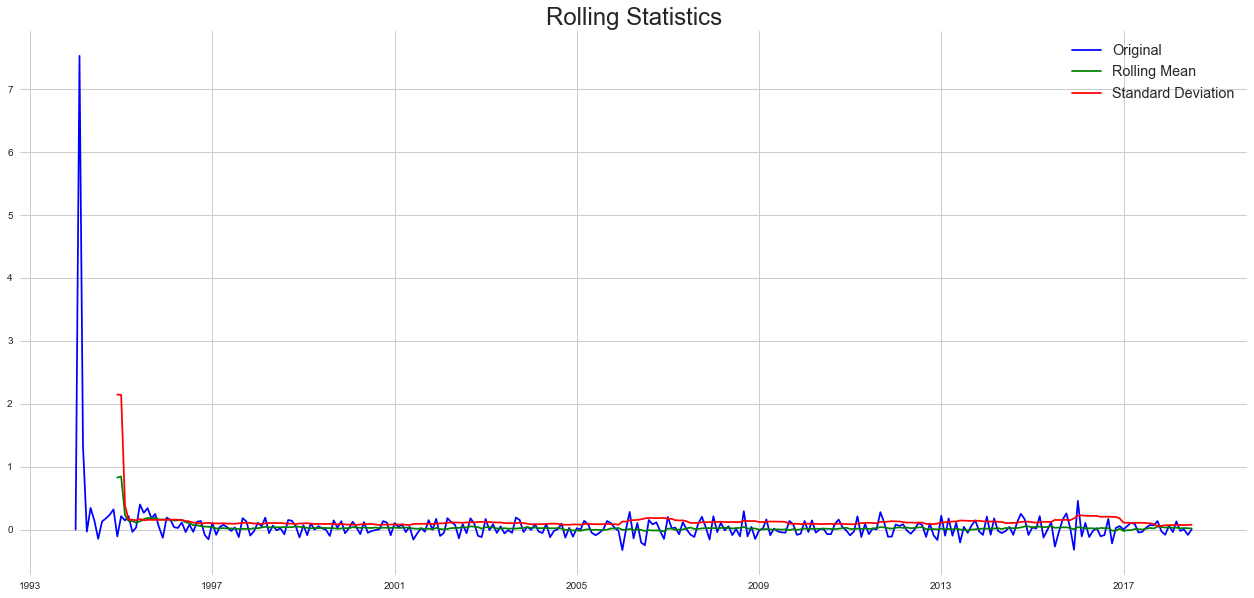

Results of Dickey-Fuller Test:
Test Statistic                  -4.168869
p-value                          0.000744
Number of Lags Used             16.000000
Number of Observations Used    278.000000
Critical Value (1%)             -3.454094
Critical Value (5%)             -2.871993
Critical Value (10%)            -2.572340
dtype: float64


In [37]:
downloads_log_diff_shift.dropna(inplace=True)
ts.test_stationarity(downloads_log_diff_shift)

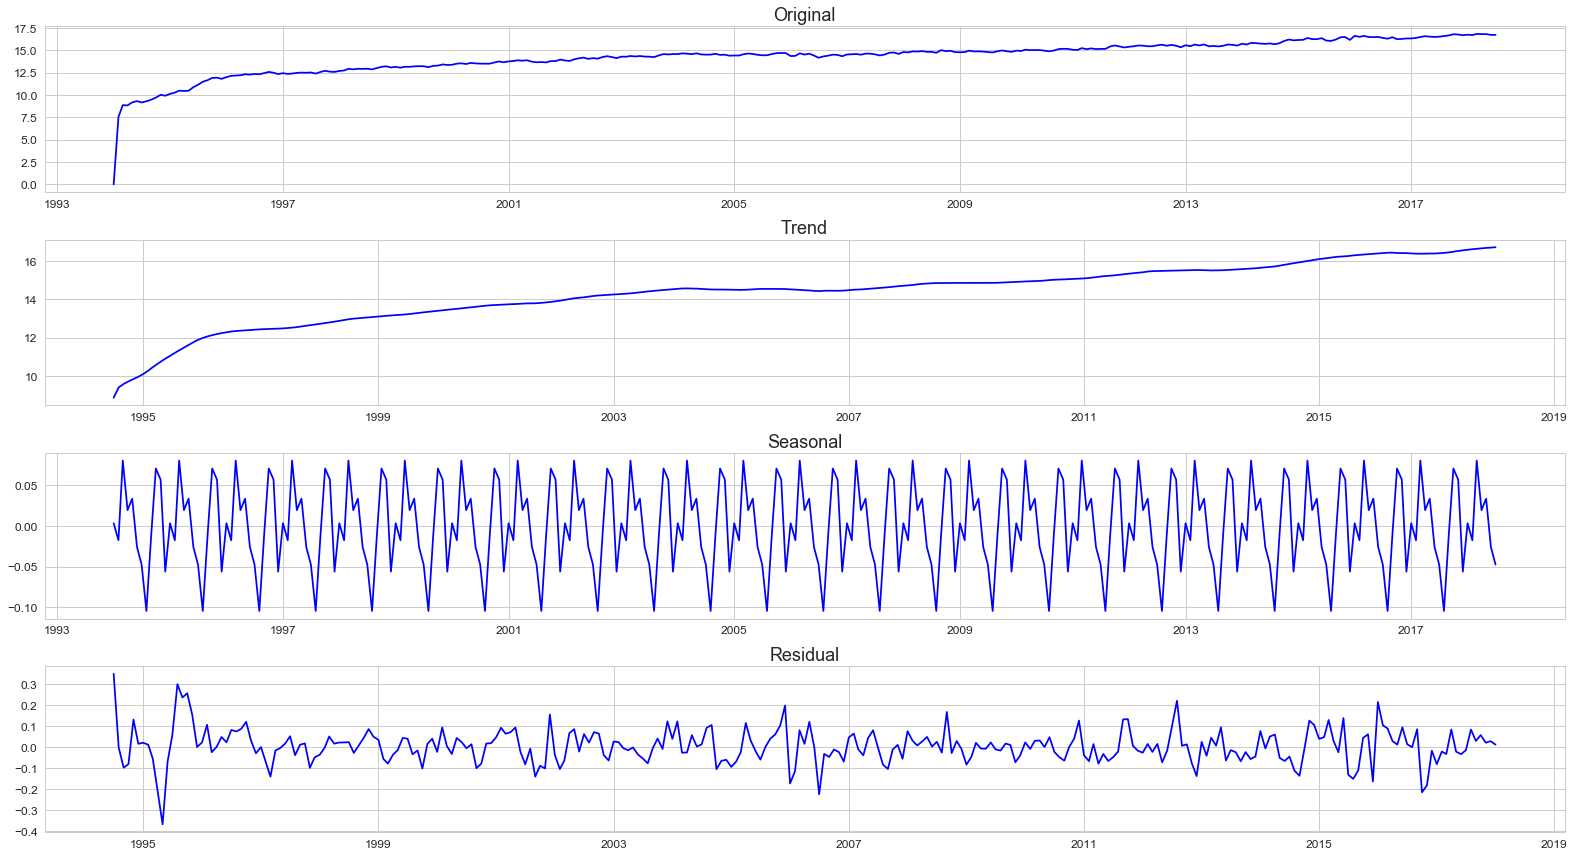

In [38]:
# Decomposing
decomposition = seasonal_decompose(downloads_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plotting
plt.figure(figsize=(22, 12))
# Original
plt.subplot(411)
plt.plot(downloads_log, color='blue')
plt.title('Original', fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# Trend
plt.subplot(412)
plt.plot(trend, color='blue')
plt.title('Trend', fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# Seasonal
plt.subplot(413)
plt.plot(seasonal, color='blue')
plt.title('Seasonal', fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# Residual
plt.subplot(414)
plt.plot(residual, color='blue')
plt.title('Residual', fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

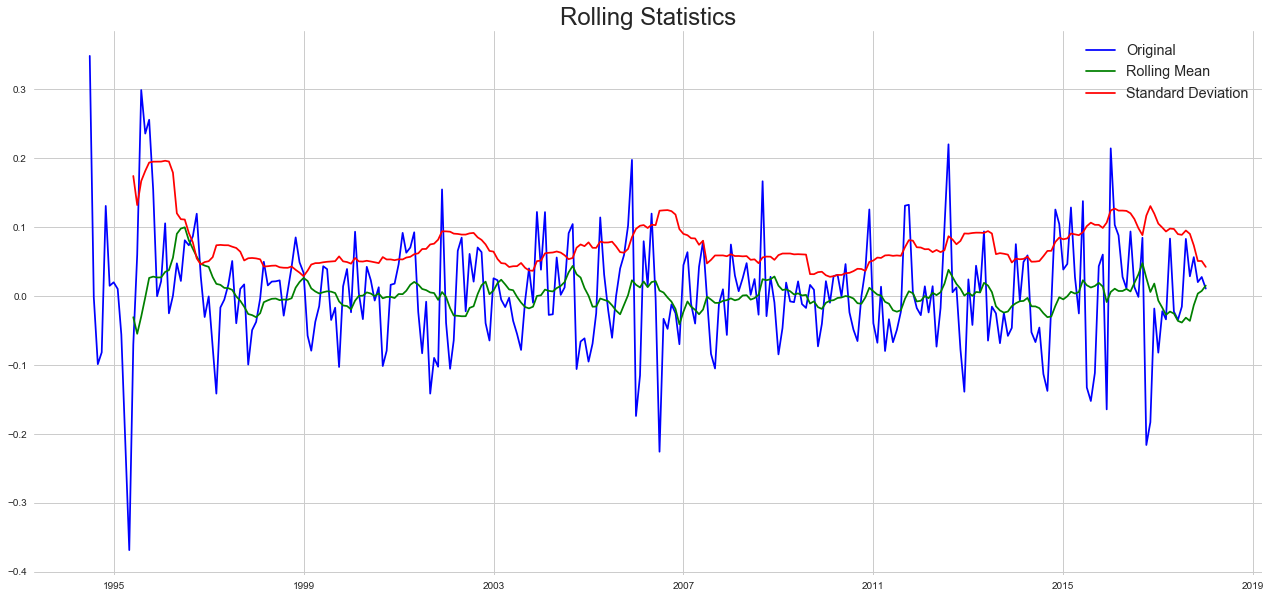

Results of Dickey-Fuller Test:
Test Statistic                -1.247789e+01
p-value                        3.138638e-23
Number of Lags Used            0.000000e+00
Number of Observations Used    2.820000e+02
Critical Value (1%)           -3.453754e+00
Critical Value (5%)           -2.871844e+00
Critical Value (10%)          -2.572261e+00
dtype: float64


In [39]:
# Checking stationarity of residuals
downloads_log_decompose_res = residual
downloads_log_decompose_res.dropna(inplace=True)
ts.test_stationarity(downloads_log_decompose_res)

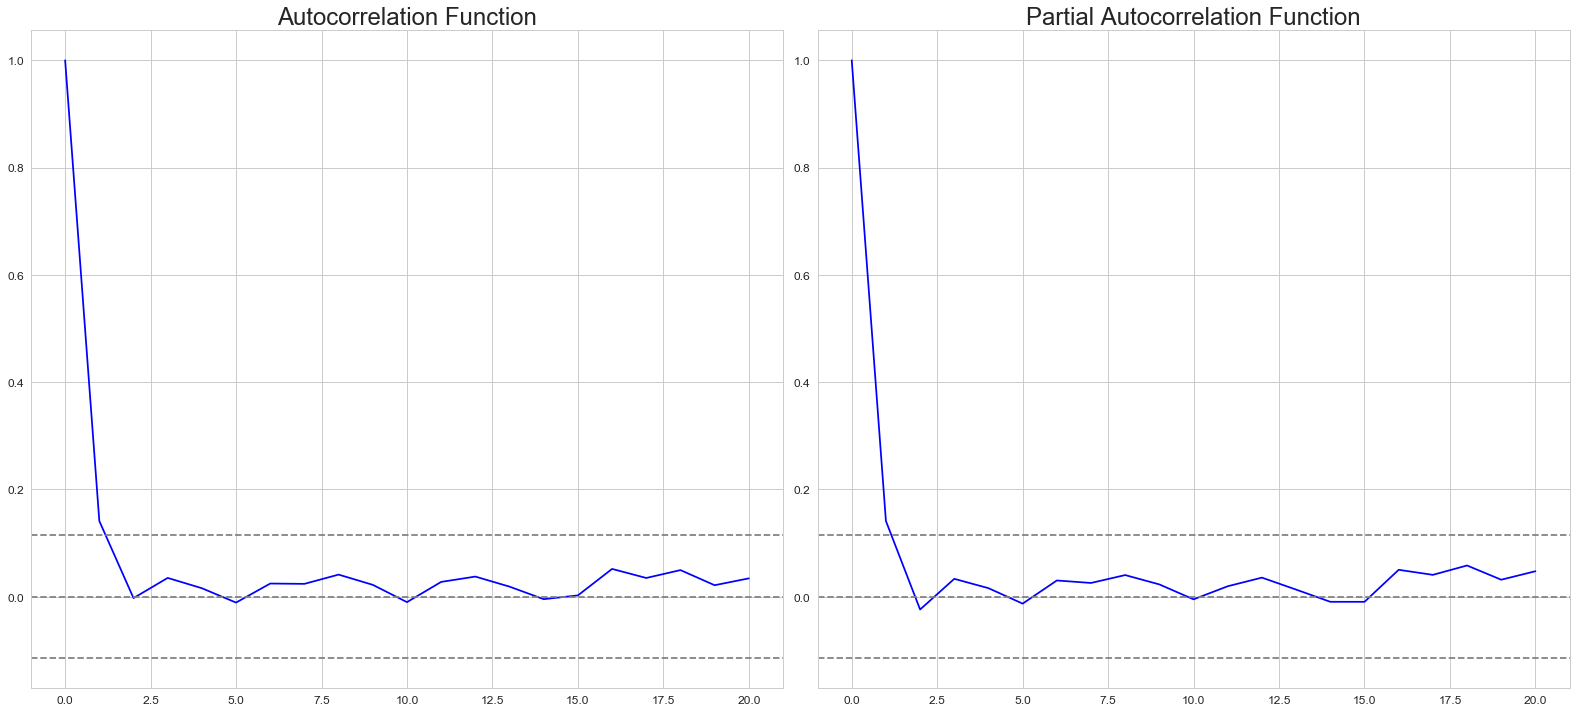

In [40]:
# Forecasting
# ACF and PACF plots:
lag_acf = acf(downloads_log_diff_shift, nlags=20)
lag_pacf = pacf(downloads_log_diff_shift, nlags=20, method='ols')

# Plotting ACF
plt.figure(figsize=(22, 10))
plt.subplot(121)
plt.plot(lag_acf, color='blue')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(downloads_log)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(downloads_log)), linestyle='--', color='gray')
plt.title('Autocorrelation Function', fontsize=24)

# Plotting PACF
plt.subplot(122)
plt.plot(lag_pacf, color='blue')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(downloads_log)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(downloads_log)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function', fontsize=24)
plt.tight_layout()

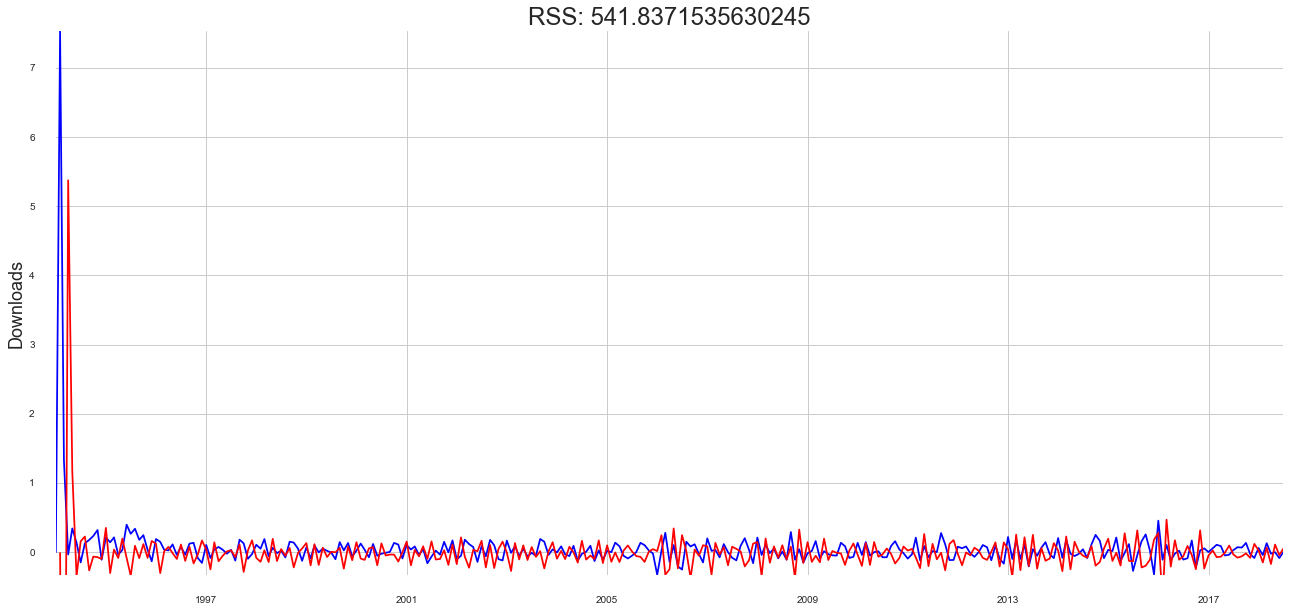

In [41]:
# AR Model
filterwarnings('ignore')
model = ARIMA(downloads_log_diff_shift, order=(1, 1, 0))
results_AR = model.fit(disp=-1)

# Plotting
ts.plot_series(data=downloads_log_diff_shift, 
               data2=results_AR.fittedvalues,
               ylabel='Downloads', 
               title='RSS: {}'.format(sum((results_AR.fittedvalues - downloads_log_diff_shift).fillna(0))**2))

In [42]:
print(results_AR.summary())

                             ARIMA Model Results                              
Dep. Variable:            D.downloads   No. Observations:                  294
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -201.403
Method:                       css-mle   S.D. of innovations              0.479
Date:                Fri, 10 Aug 2018   AIC                            408.806
Time:                        09:57:49   BIC                            419.857
Sample:                    02-01-1994   HQIC                           413.232
                         - 07-01-2018                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0121      0.015     -0.808      0.420      -0.041       0.017
ar.L1.D.downloads    -0.8707      0.064    -13.639      0.000      -0.996      -0.746
                        

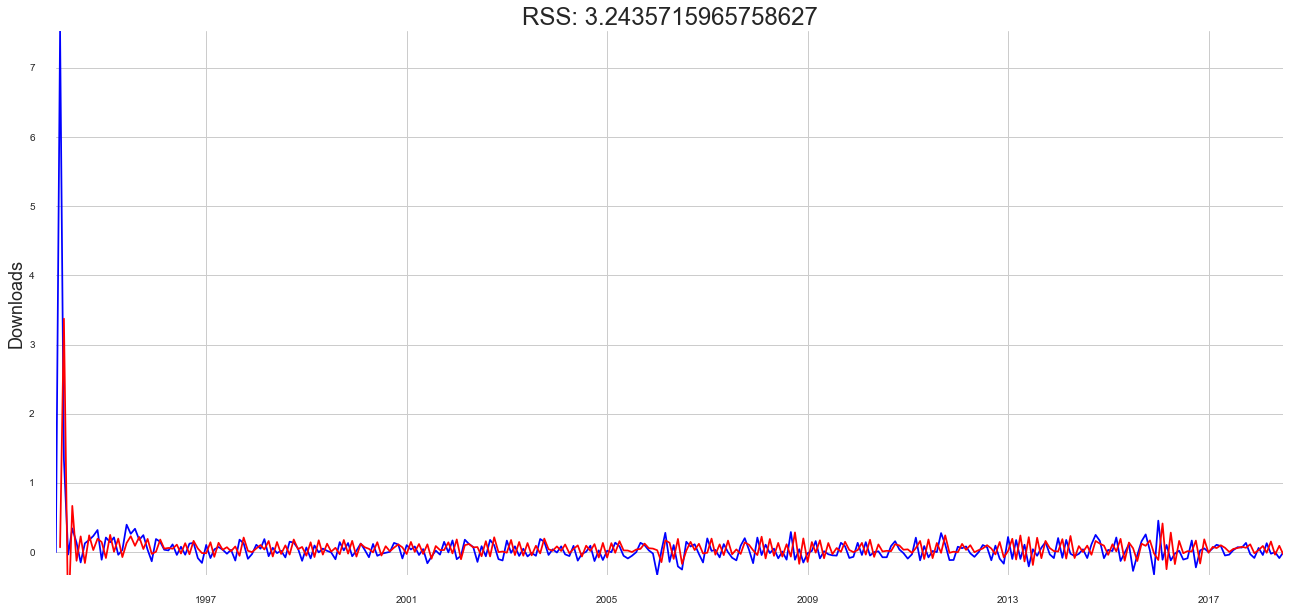

In [43]:
# MA Model
filterwarnings('ignore')
model = ARIMA(downloads_log, order=(0, 1, 1))
results_MA = model.fit(disp=-1)

# Plotting
ts.plot_series(data=downloads_log_diff_shift, 
               data2=results_MA.fittedvalues,
               ylabel='Downloads', 
               title='RSS: {}'.format(sum((results_MA.fittedvalues - downloads_log_diff_shift).fillna(0))**2))

In [44]:
print(results_MA.summary())

                             ARIMA Model Results                              
Dep. Variable:            D.downloads   No. Observations:                  294
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -167.955
Method:                       css-mle   S.D. of innovations              0.428
Date:                Fri, 10 Aug 2018   AIC                            341.909
Time:                        09:57:50   BIC                            352.960
Sample:                    02-01-1994   HQIC                           346.335
                         - 07-01-2018                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0706      0.040      1.762      0.079      -0.008       0.149
ma.L1.D.downloads     0.6051      0.055     10.965      0.000       0.497       0.713
                        

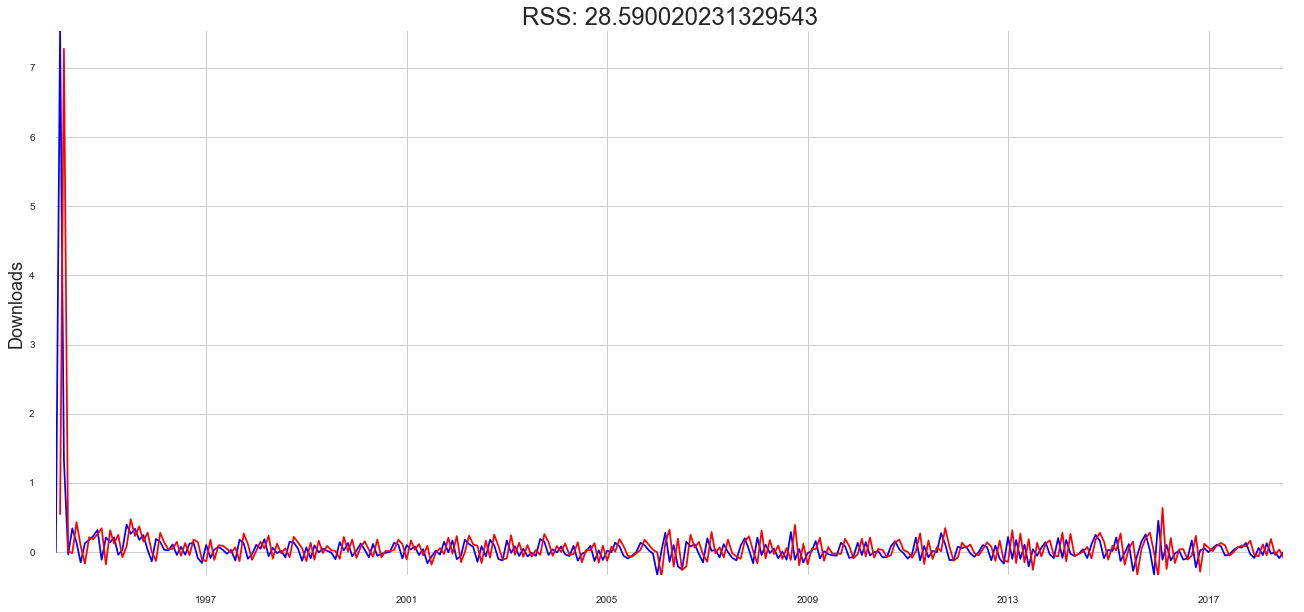

In [45]:
# ARIMA Model
filterwarnings('ignore')
model = ARIMA(downloads_log, order=(1, 1, 1))
results_ARIMA = model.fit(disp=-1)

# Plotting
ts.plot_series(data=downloads_log_diff_shift, 
               data2=results_ARIMA.fittedvalues,
               ylabel='Downloads',
               title='RSS: {}'.format(sum((results_ARIMA.fittedvalues - downloads_log_diff_shift).fillna(0))**2))

In [46]:
print(results_ARIMA.summary())

                             ARIMA Model Results                              
Dep. Variable:            D.downloads   No. Observations:                  294
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -154.968
Method:                       css-mle   S.D. of innovations              0.408
Date:                Fri, 10 Aug 2018   AIC                            317.936
Time:                        09:57:50   BIC                            332.670
Sample:                    02-01-1994   HQIC                           323.837
                         - 07-01-2018                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.5481      0.778      0.704      0.482      -0.977       2.073
ar.L1.D.downloads     0.9484      0.065     14.497      0.000       0.820       1.077
ma.L1.D.downloads     0.

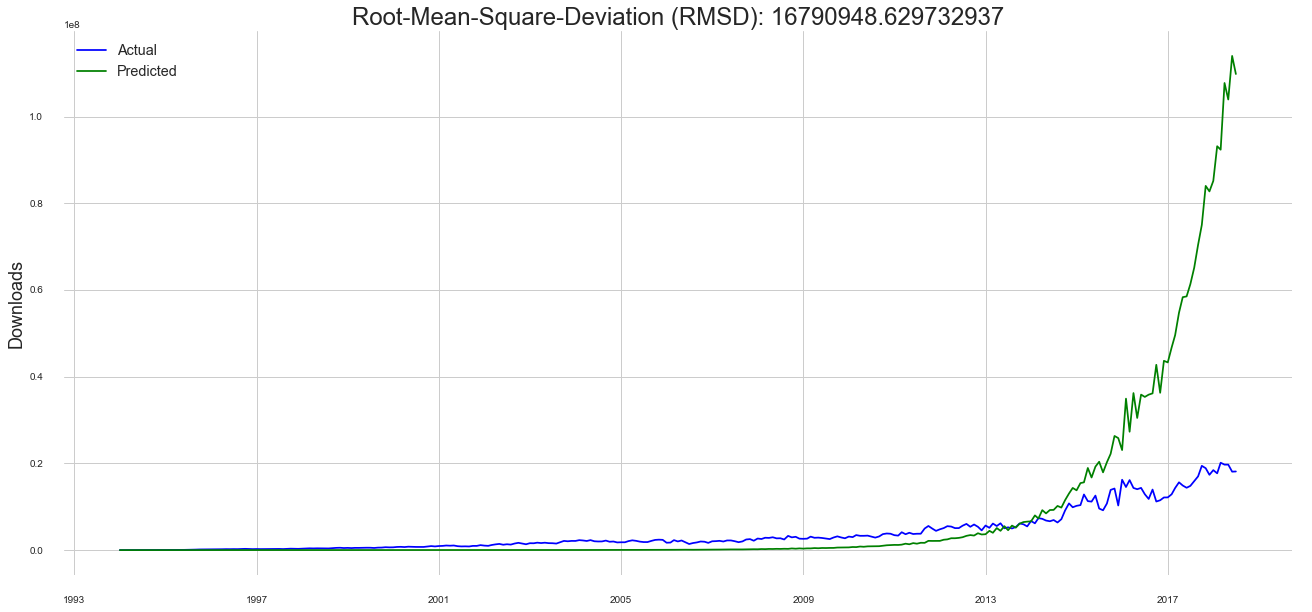

In [47]:
# By MA
# Reversing to the original scale
predictions_MA_diff = pd.Series(results_MA.fittedvalues, copy=True)

# Cumulative sum
predictions_MA_diff_cumsum = predictions_MA_diff.cumsum()

# Adding the base number
predictions_MA_log = pd.Series(downloads_log.ix[0], index=downloads_log.index)
predictions_MA_log = predictions_MA_log.add(predictions_MA_diff_cumsum, fill_value=0)

# Taking the exponent
predictions_MA = np.exp(predictions_MA_log)

# Plotting
ts.plot_predictions(data=downloads, 
                    data2=predictions_MA, 
                    ylabel='Downloads', 
                    title='Root-Mean-Square-Deviation (RMSD): {}'.format(np.sqrt(sum((
                        predictions_MA - downloads)**2)/len(downloads))))

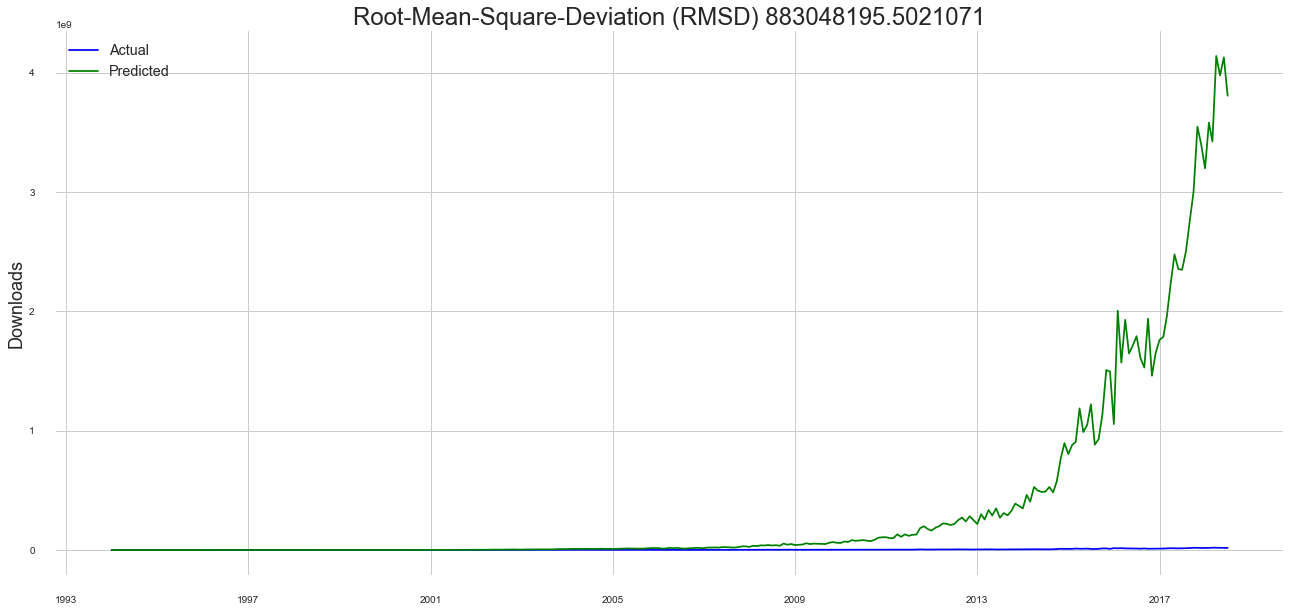

In [48]:
# By ARIMA
# Reversing to the original scale
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)

# Cumulative sum
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()

# Adding the base number
predictions_ARIMA_log = pd.Series(downloads_log.ix[0], index=downloads_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)

# Taking the exponent
predictions_ARIMA = np.exp(predictions_ARIMA_log)

# Plotting
ts.plot_predictions(data=downloads,
                    data2=predictions_ARIMA,
                    ylabel='Downloads',
                    title='Root-Mean-Square-Deviation (RMSD) {}'.format(np.sqrt(sum((
                        predictions_ARIMA - downloads)**2)/len(downloads))))

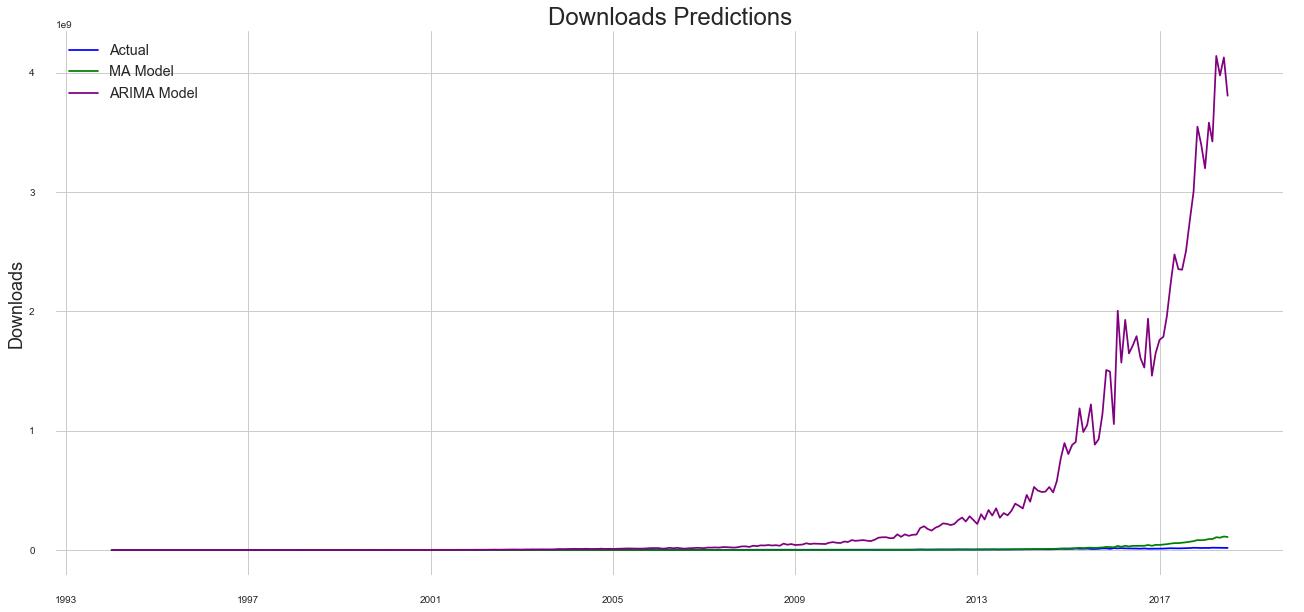

In [49]:
# Plotting
ts.plot_predictions(data=downloads,
                    data2=predictions_MA,
                    data3=predictions_ARIMA,
                    ylabel='Downloads',
                    title='Downloads Predictions',
                    l2='MA Model',
                    l3='ARIMA Model')

### Summary

The arXiv downloads have a different fundamental structure compared to the submissions. However, the models that where preferable for predicting submissions similar to those preferable for downloads - certain models were a better of both data sets compared to other types of models. We provide a contrast between the two models.

We selected the following models:

> **MA** - this model the lowest RSS compared to the other two models.

> **ARIMA** - similar as in submissions, this model had better AIC, BIC and HQIC values.

We used both models to make predictions and obtained the following results:

| **Measure** |    **MA Model**   |   **ARIMA Model**   |
| :---------: | :---------------: | :-----------------: |
|     RMSD    |    16790948.630   |   883048195.502     |

The **MA** model has a tighter fit to the downloads data and also has a better deviation from the actual values in prediction compared to the **ARIMA** model. However, despite having a tighter fit and lower deviation, the **MA** model does not model the data well. The deviations in prediction are significantly high.

### Recommendations

Having modelled the arXiv submissions and downloads, the submissions model is unreliable but may be usable under certain conditions for predictions. The model can be retained with adjusted parameters before being used for any predictive work.

Other the other hand, the downloads models does not fit the model well. This is despite the snug fit of the **MA** model, which performs badly in attempting to predict giving out deviations of $10^6$. The **ARIMA** performs much worse than the **MA** model. 

Retaining this model would not be useful and would produce misleading results. However, the **MA** model parameters could be readjusted to fit the actual data better and perhaps reduce the deviation in predictions.

The final recommendation is that the data should be model with an algorithm that models time-series data better with a closer fit.

***